# Curso de Big Data. Otoño 2024 - Grupo 4
# Trabajo Práctico 4
## Integrantes: Federico Saucedo, Manuel Soares Gache y Maximiliano Cucher

# Parte I: Analisis de la base de hogares y calculo de pobreza

In [1]:
import pandas as pd
df_hogar = pd.read_excel('/Users/manuelsoaresgache/Desktop/TP4 Big Data/usu_hogar_T423.xlsx')
df_indi = pd.read_excel('/Users/manuelsoaresgache/Desktop/Big data/Big data - TP3/usu_individual_T423.xlsx')

## Ejercicio 2

Al igual que en el TP3 nos quedamos solo con las obsavaciones  que corresponden a los aglomerados de Ciudad Autonoma de Buenos Aires o del Gran Buenos Aires.

In [2]:
# Códigos de aglomerado para Ciudad Autónoma de Buenos Aires y Gran Buenos Aires
codigos_buenos_aires = [32, 33]
# Filtrar los datos
df_a = df_hogar[df_hogar['AGLOMERADO'].isin(codigos_buenos_aires)]
df2_a = df_indi[df_indi['AGLOMERADO'].isin(codigos_buenos_aires)]

Ahora mergeamos las dos base de datos eliminando las columnas repetidas entre ambas.

In [3]:
import pandas as pd

# Fusionar los DataFrames df2_a y df_a
merged_df = pd.merge(df2_a, df_a, on=['CODUSU', 'NRO_HOGAR'], how='left', suffixes=('', '_df'))

# Identificar y eliminar manualmente las columnas duplicadas
columnas_duplicadas = []
columnas_procesadas = set()
for columna in merged_df.columns:
    nombre_columna = columna.split('_df')[0]
    if nombre_columna in columnas_procesadas:
        columnas_duplicadas.append(columna)
    else:
        columnas_procesadas.add(nombre_columna)

merged_df = merged_df.drop(columns=columnas_duplicadas)

## Ejercicio 3

En primer lugar vemso que variables tienen valores negativos.

In [4]:
columnas_numericas = merged_df.select_dtypes(include='number')

# Identificar las columnas que contienen valores negativos
columnas_con_negativos = columnas_numericas.columns[(columnas_numericas < 0).any()].tolist()

print(f"Columnas con valores negativos: {columnas_con_negativos}")

Columnas con valores negativos: ['CH06', 'PP06C', 'PP06D', 'PP08D1', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3', 'P21', 'TOT_P12', 'P47T', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V21_M', 'T_VI']


In [5]:
# Contar la cantidad de valores negativos en la columna CH06
valores_negativos_ch06 = (merged_df['CH06'] < 0).sum()

# Imprimir la cantidad de valores negativos
print("Cantidad de valores negativos en la columna CH06:", valores_negativos_ch06)


Cantidad de valores negativos en la columna CH06: 48


In [6]:
# Filtrar el DataFrame para mantener solo las filas donde CH06 no es negativo
merged_df_filtrado = merged_df[merged_df['CH06'] >= 0]

Una vez que eliminamos los valores negativos de edad, procedemos a eliminar los outliers mediente el metdodo IQR.

In [7]:
import pandas as pd

# Suponiendo que dt_3 es tu DataFrame
# Asegúrate de que todas las columnas numéricas son tratadas para detectar outliers

# Definir una función para eliminar outliers usando el método IQR
def eliminar_outliers_iqr(df):
    # Seleccionar solo las columnas numéricas
    df_numerico = df.select_dtypes(include=['float64', 'int64'])

    # Calcular el primer y tercer cuartil (Q1 y Q3)
    Q1 = df_numerico.quantile(0.001)
    Q3 = df_numerico.quantile(0.999)

    # Calcular el rango intercuartílico (IQR)
    IQR = Q3 - Q1

    # Definir los límites para identificar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar los datos para eliminar outliers
    df_sin_outliers = df[~((df_numerico < lower_bound) | (df_numerico > upper_bound)).any(axis=1)]
    
    return df_sin_outliers

# Eliminar los outliers del DataFrame dt_3
df_3_sin_outliers = eliminar_outliers_iqr(merged_df_filtrado)

# Mostrar la cantidad de observaciones antes y después de eliminar outliers
print(f"Observaciones antes de eliminar outliers: {merged_df_filtrado.shape[0]}")
print(f"Observaciones después de eliminar outliers: {df_3_sin_outliers.shape[0]}")

Observaciones antes de eliminar outliers: 7332
Observaciones después de eliminar outliers: 7262


Una vez eliminados los ouliers, vemos donde se encuantran los missing values.

In [8]:
# Seleccionar las columnas de tipo 'object' (cadenas de texto y variables categóricas)
columnas_categoricas_y_strings = df_3_sin_outliers.select_dtypes(include=['object'])

# Imprimir las columnas de tipo 'object'
print("Variables categóricas y de tipo string:")
print(columnas_categoricas_y_strings.columns)

Variables categóricas y de tipo string:
Index(['CODUSU', 'MAS_500', 'CH05', 'PP09A_ESP', 'PP09C_ESP', 'IV1_ESP',
       'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP'],
      dtype='object')


In [9]:
# Lista de variables de interés
variables_interes = ['CODUSU', 'MAS_500', 'CH05', 'PP09A_ESP', 'PP09C_ESP', 'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP']

# Calcular el número de valores faltantes para cada variable
missing_values_por_variable = df_3_sin_outliers[variables_interes].isnull().sum()

# Imprimir el número de valores faltantes por variable
print("Número de valores faltantes por variable:")
print(missing_values_por_variable)


Número de valores faltantes por variable:
CODUSU          0
MAS_500         0
CH05            0
PP09A_ESP    7246
PP09C_ESP    7262
IV1_ESP      7242
IV3_ESP      7255
IV7_ESP      7231
II7_ESP      7246
II8_ESP      7056
dtype: int64


En cuanto a los missing values nos dimos cuanta que la mejor estartegia es dejarlos como missing ya que si usamos la media para reemplzarlos, la mayoria de las varaibels son discretas por lo que es muy posible que no tenga sentido remplzar el missing value por 3,5 por ejemplo. Asimismo, vemos que las variables que no son continuas son las de ingreso, pero no nos parece correcto remplzarlas por la media ya que si no si reemplamos por ejemplo la vraibel ITF, parecera que todos contestaron.

## Ejercicio 4

In [10]:
import pandas as pd

# Desactivar las advertencias de SettingWithCopyWarning temporalmente
pd.options.mode.chained_assignment = None  # default='warn'

# Proporción de niños en el hogar
df_3_sin_outliers['proporcion_ninos'] = df_3_sin_outliers['IX_MEN10'] / df_3_sin_outliers['IX_TOT']

# Proporción de personas que trabajan en una oficina en el hogar
df_3_sin_outliers['trabaja'] = df_3_sin_outliers['PP04G'].apply(lambda x: 1 if x in [1] else 0)
df_3_sin_outliers['proporcion_trabaja_of'] = df_3_sin_outliers['trabaja'] / df_3_sin_outliers['IX_TOT']

# Proporción de personas que trabajan en la calle en el hogar
df_3_sin_outliers['trabaja'] = df_3_sin_outliers['PP04G'].apply(lambda x: 1 if x in [2,9] else 0)
df_3_sin_outliers['proporcion_trabaja_calle'] = df_3_sin_outliers['trabaja'] / df_3_sin_outliers['IX_TOT']

# Proporción del ingreso que viene dado por ayuda social
df_3_sin_outliers['proporcion_ayuda_social'] = df_3_sin_outliers['V6'] + df_3_sin_outliers['V5'] / (df_3_sin_outliers['V1'] + df_3_sin_outliers['V6']) + df_3_sin_outliers['V5']

# Restaurar el comportamiento anterior de las advertencias
pd.options.mode.chained_assignment = 'warn'


In [11]:
print(df_3_sin_outliers[['proporcion_ninos', 'proporcion_trabaja_of', 'proporcion_trabaja_calle','proporcion_ayuda_social']].head())

   proporcion_ninos  proporcion_trabaja_of  proporcion_trabaja_calle  \
0               0.0               0.000000                       0.0   
1               0.0               0.000000                       0.0   
2               0.0               0.000000                       0.0   
3               0.0               0.000000                       0.0   
4               0.0               0.333333                       0.0   

   proporcion_ayuda_social  
0                 4.666667  
1                 4.666667  
2                 4.666667  
3                 4.666667  
4                 4.666667  


## Ejercicio 5

In [12]:
variables = ["IV1", "IV2","IV8", "V1", "IX_TOT"]

# Calcular estadísticas descriptivas para las variables seleccionadas
estadisticas_descriptivas = df_3_sin_outliers[variables].describe()

print(estadisticas_descriptivas)

               IV1          IV2          IV8           V1       IX_TOT
count  7262.000000  7262.000000  7262.000000  7262.000000  7262.000000
mean      1.321261     3.061002     1.002066     1.110989     3.667447
std       0.547873     1.102262     0.045404     0.314140     1.863689
min       1.000000     1.000000     1.000000     1.000000     1.000000
25%       1.000000     2.000000     1.000000     1.000000     2.000000
50%       1.000000     3.000000     1.000000     1.000000     3.000000
75%       2.000000     4.000000     1.000000     1.000000     4.000000
max       6.000000     8.000000     2.000000     2.000000    12.000000


## Ejercicio 6

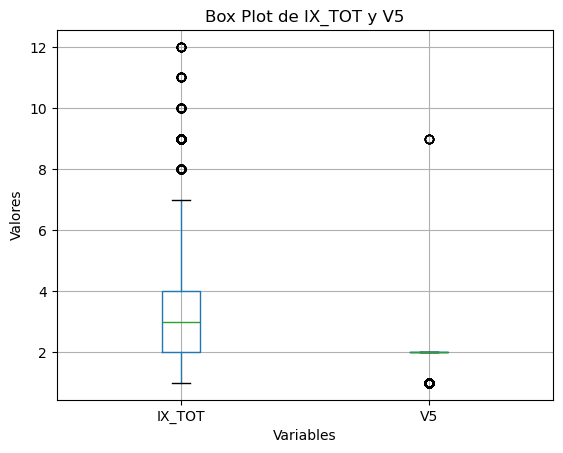

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

# Supongamos que 'data' es tu DataFrame que contiene las variables 'X_TOT' y 'V5'
df_3_sin_outliers.boxplot(column=['IX_TOT', 'V5'])

# Ajustar el título y las etiquetas de los ejes
plt.title('Box Plot de IX_TOT y V5')
plt.xlabel('Variables')
plt.ylabel('Valores')

# Mostrar el box plot
plt.show()

plt.savefig('Ej6.png')

## Ejercicio 7

In [14]:
import pandas as pd

# Crear un diccionario para la tabla de equivalencia por sexo y edad
adulto_equiv = {
    'edad_min': [0, 10, 18, 30, 46, 61, 76],
    'edad_max': [9, 17, 29, 45, 60, 75, 120],  # Uso 120 para cubrir todos hasta "más de 75 años"
    'Mujeres': [0.69, 0.77, 0.76, 0.77, 0.76, 0.67, 0.63],
    'Varones': [0.69, 1.04, 1.02, 1.00, 1.00, 0.83, 0.74]
}
tabla_equiv = pd.DataFrame(adulto_equiv)

# Función para buscar el equivalente de adulto basado en edad y sexo
def get_adulto_equiv(edad, sexo):
    # Filtrar por rango de edad
    row = tabla_equiv[(tabla_equiv['edad_min'] <= edad) & (tabla_equiv['edad_max'] >= edad)]
    if sexo == 1:  # Hombre
        return row['Varones'].values[0]
    else:  # Mujer
        return row['Mujeres'].values[0]

# Aplicar la función para crear la columna 'adulto_equiv'
df_7 = df_3_sin_outliers.copy()  # Crear una copia del DataFrame para evitar SettingWithCopyWarning
df_7['adulto_equiv'] = df_7.apply(lambda row: get_adulto_equiv(row['CH06'], row['CH04']), axis=1)

# Sumar la columna 'adulto_equiv' para las personas que pertenecen al mismo hogar. CODUSU sirve para agrupar a las peronas por hogar.
df_7['ad_equiv_hogar'] = df_7.groupby('CODUSU')['adulto_equiv'].transform('sum')

# Mostrar el resultado
print(df_7[['CH06', 'CH04', 'adulto_equiv', 'ad_equiv_hogar']].head())

   CH06  CH04  adulto_equiv  ad_equiv_hogar
0    76     1          0.74            1.37
1    79     2          0.63            1.37
2    65     1          0.83            6.71
3    66     2          0.67            6.71
4    49     2          0.76            2.82


## Ejercicio 8

In [15]:
# Crear una base de datos con las observaciones donde se respondió la pregunta sobre ITF
respondieron = df_7[df_7['ITF'] != 0]

# Crear una base de datos con las observaciones donde no se respondió la pregunta sobre ITF
norespondieron = df_7[df_7['ITF'] == 0]

In [16]:
# Valor de la Canasta Básica Total para un adulto equivalente
canasta_basica_total = 132853.3

# Calcular el ingreso necesario para cada hogar
respondieron['ingreso_necesario'] = canasta_basica_total * respondieron['ad_equiv_hogar']

# Mostrar las primeras filas del DataFrame con la nueva columna para comprobar que se creo la columna ingreso_necesario
print(respondieron.head())

                          CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  H15  \
0  TQRMNOTUUHJMLPCDEIIAD00801670  2023          4          1           1    1   
1  TQRMNOTUUHJMLPCDEIIAD00801670  2023          4          1           2    1   
4  TQRMNOPUTHKLMNCDEIIAD00791268  2023          4          1           1    1   
5  TQRMNOPUTHKLMNCDEIIAD00791268  2023          4          1           2    1   
6  TQRMNOPUTHKLMNCDEIIAD00791268  2023          4          1           3    1   

   REGION MAS_500  AGLOMERADO  PONDERA  ...  VII2_3  VII2_4 proporcion_ninos  \
0       1       S          32     1775  ...       0       0              0.0   
1       1       S          32     1775  ...       0       0              0.0   
4       1       S          32     3129  ...       0       0              0.0   
5       1       S          32     3129  ...       0       0              0.0   
6       1       S          32     3129  ...       0       0              0.0   

   trabaja  proporcion_trabaja_o

/var/folders/6w/8tcgqntn20ggvsnbmjxnd3_m0000gn/T/ipykernel_84622/3109995350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario'] = canasta_basica_total * respondieron['ad_equiv_hogar']


In [17]:
# Agregar la columna "pobre" con valor 1 si ITF es menor al ingreso necesario, y 0 en caso contrario
respondieron['pobre'] = (respondieron['ITF'] < respondieron['ingreso_necesario']).astype(int)

# Calcular la cantidad de personas identificadas como pobres
cantidad_de_pobres = respondieron['pobre'].sum()

# Calcular el porcentaje de personas identificadas como pobres
total_personas = len(respondieron)
porcentaje_de_pobres = (cantidad_de_pobres / total_personas) * 100

# Mostrar las primeras filas del DataFrame con la nueva columna para comprobar si se agrego la columan pobre
print(respondieron.head())

# Imprimir la cantidad y el porcentaje de pobres identificados
print("Cantidad de personas identificadas como pobres:", cantidad_de_pobres)
print("Porcentaje de personas identificadas como pobres: {:.2f}%".format(porcentaje_de_pobres))

                          CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  H15  \
0  TQRMNOTUUHJMLPCDEIIAD00801670  2023          4          1           1    1   
1  TQRMNOTUUHJMLPCDEIIAD00801670  2023          4          1           2    1   
4  TQRMNOPUTHKLMNCDEIIAD00791268  2023          4          1           1    1   
5  TQRMNOPUTHKLMNCDEIIAD00791268  2023          4          1           2    1   
6  TQRMNOPUTHKLMNCDEIIAD00791268  2023          4          1           3    1   

   REGION MAS_500  AGLOMERADO  PONDERA  ...  VII2_4  proporcion_ninos trabaja  \
0       1       S          32     1775  ...       0               0.0       0   
1       1       S          32     1775  ...       0               0.0       0   
4       1       S          32     3129  ...       0               0.0       0   
5       1       S          32     3129  ...       0               0.0       0   
6       1       S          32     3129  ...       0               0.0       0   

   proporcion_trabaja_of  

/var/folders/6w/8tcgqntn20ggvsnbmjxnd3_m0000gn/T/ipykernel_84622/2770076219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobre'] = (respondieron['ITF'] < respondieron['ingreso_necesario']).astype(int)


## Ejercicio 9

In [18]:
# Crear una sola observación por hogar sumando el ponderador PONDIH
observacion_hogar = df_7.groupby('CODUSU')['PONDIH'].first().reset_index()

# Calcular la suma de los ponderadores para obtener el total de la población
total_poblacion = observacion_hogar['PONDIH'].sum()

# Calcular la cantidad de hogares identificados como pobres
hogares_pobres = respondieron.groupby('CODUSU')['pobre'].max().sum()

# Calcular la tasa de hogares bajo la línea de pobreza
tasa_hogares_pobres = (hogares_pobres / len(observacion_hogar)) * 100

# Imprimir la tasa de hogares bajo la línea de pobreza
print("Tasa de hogares bajo la línea de pobreza: {:.2f}%".format(tasa_hogares_pobres))


Tasa de hogares bajo la línea de pobreza: 19.27%


# Parte II: Construccion de funciones

## Ejercicio 1

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns

def evalua_metodo(model, X_train, y_train, X_test, y_test):
    # Ajustar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)
    
    # Predecir las etiquetas para los datos de prueba
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Calcular la curva ROC y el AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Calcular el accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()
    
    # Graficar la curva ROC
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    # Devolver las métricas en un diccionario
    metrics = {
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr, thresholds),
        'auc': auc,
        'accuracy': accuracy
    }
    
    return metrics


## Ejercicio 2

In [20]:
import numpy as np
from sklearn.model_selection import KFold

def cross_validation(model, X, y, k):
    # Inicializar KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Inicializar listas para guardar las métricas
    accuracy_list = []
    auc_list = []
    confusion_matrices = []
    
    # Realizar la validación cruzada
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Evaluar el modelo
        metrics = evalua_metodo(model, X_train, y_train, X_test, y_test)
        
        # Guardar las métricas de esta iteración
        accuracy_list.append(metrics['accuracy'])
        auc_list.append(metrics['auc'])
        confusion_matrices.append(metrics['confusion_matrix'])
    
    # Calcular las métricas promedio
    mean_accuracy = np.mean(accuracy_list)
    mean_auc = np.mean(auc_list)
    
    # Sumar todas las matrices de confusión
    sum_confusion_matrix = np.sum(confusion_matrices, axis=0)
    
    # Devolver las métricas promedio y la matriz de confusión sumada
    return {
        'mean_accuracy': mean_accuracy,
        'mean_auc': mean_auc,
        'sum_confusion_matrix': sum_confusion_matrix
    }

## Ejercicio 3

In [21]:
def evalua_config(model_class, param_grid, X, y, k):
    """
    Evalúa diferentes configuraciones de hiperparámetros y devuelve la configuración con el menor error.

    Args:
    model_class: Clase del modelo a evaluar.
    param_grid: Lista de diccionarios con las configuraciones de hiperparámetros.
    X: Array de características.
    y: Array de etiquetas.
    k: Número de particiones en la validación cruzada.

    Returns:
    best_params: Configuración con el menor error promedio.
    best_score: El menor error promedio obtenido.
    """
    best_score = float('inf')
    best_params = None

    for params in param_grid:
        # Instanciar el modelo con los parámetros actuales
        model = model_class(**params)
        
        # Realizar la validación cruzada con los parámetros actuales
        results = cross_validation(model, X, y, k)
        
        # Calcular el error promedio (1 - accuracy)
        mean_error = 1 - results['mean_accuracy']
        
        print(f"Evaluando configuración: {params}")
        print(f"Error Promedio: {mean_error:.4f}")

        # Actualizar la mejor configuración si se encuentra un error menor
        if mean_error < best_score:
            best_score = mean_error
            best_params = params

    return best_params, best_score

## Ejercicio 4

In [22]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

def evalua_multiples_metodos(X, y, k):
    resultados = []

    # Definir el rango de hiperparámetros para la regresión logística
    param_grid_logistic = [{'C': 1/lambda_val} for lambda_val in [0.01, 0.1, 1, 10, 100]]

    # Evaluar la regresión logística para optimizar el parámetro de regularización
    best_params_logistic, _ = evalua_config(LogisticRegression, param_grid_logistic, X, y, k)
    logistic_model = LogisticRegression(max_iter=2000, **best_params_logistic)

    # Evaluar el modelo de regresión logística
    metrics_logistic = cross_validation(logistic_model, X, y, k)
    metrics_logistic['model'] = 'Logistic Regression'
    metrics_logistic['best_params'] = best_params_logistic
    resultados.append(metrics_logistic)

    # Definir y evaluar el modelo de análisis de discriminante lineal
    lda_model = LinearDiscriminantAnalysis()
    metrics_lda = cross_validation(lda_model, X, y, k)
    metrics_lda['model'] = 'Linear Discriminant Analysis'
    metrics_lda['best_params'] = {}
    resultados.append(metrics_lda)

    # Definir y evaluar el modelo KNN con K = 3
    knn_model = KNeighborsClassifier(n_neighbors=3)
    metrics_knn = cross_validation(knn_model, X, y, k)
    metrics_knn['model'] = 'K-Nearest Neighbors (K=3)'
    metrics_knn['best_params'] = {'n_neighbors': 3}
    resultados.append(metrics_knn)

    # Crear un DataFrame con los resultados
    df_resultados = pd.DataFrame(resultados)

    # Reordenar las columnas para que 'model' y 'best_params' estén al principio
    cols = ['model', 'best_params'] + [col for col in df_resultados.columns if col not in ['model', 'best_params']]
    df_resultados = df_resultados[cols]

    return df_resultados

# Parte III: Clasificacion y regularizacion

## Ejercicio 1

In [23]:
# Lista de variables relacionadas con ingresos y columnas adicionales a eliminar. notar que la unica varaible que cambia es ingreso_necesario
columnas_a_eliminar1 = ['PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3', 
                       'P21', 'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCUR', 'PDECOCUR', 
                       'ADECOCUR', 'PONDIIO', 'TOT_P12', 'P47T', 'DECINDR', 'IDECINDR', 
                       'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR', 'PONDII', 'V2_M', 
                       'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 
                       'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'ITF', 'DECIFR', 'IDECIFR', 
                       'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 
                       'IDECCFR', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR', 'PONDIH',
                       'adulto_equiv', 'ad_equiv_hogar', 'ingreso_necesario', 'CODUSU', 'MAS_500', 'CH05', 'PP09A_ESP', 'PP09C_ESP', 'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP']

columnas_a_eliminar2 = ['PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3', 
                       'P21', 'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCUR', 'PDECOCUR', 
                       'ADECOCUR', 'PONDIIO', 'TOT_P12', 'P47T', 'DECINDR', 'IDECINDR', 
                       'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR', 'PONDII', 'V2_M', 
                       'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 
                       'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'ITF', 'DECIFR', 'IDECIFR', 
                       'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 
                       'IDECCFR', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR', 'PONDIH',
                       'adulto_equiv', 'ad_equiv_hogar', 'CODUSU', 'MAS_500', 'CH05', 'PP09A_ESP', 'PP09C_ESP', 'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP']
# Eliminar las columnas especificadas de la base 'respondieron'
respondieron = respondieron.drop(columns=columnas_a_eliminar1)

# Eliminar las columnas especificadas de la base 'norespondieron'
norespondieron = norespondieron.drop(columns=columnas_a_eliminar2)

In [24]:
print(respondieron.shape)

(4329, 186)


In [25]:
print(norespondieron.shape)

(2933, 185)


In [26]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Suponiendo que 'respondieron' ya está cargado y preparado
# Definir la variable dependiente 'y' y las independientes 'X'
X = respondieron.drop(columns=['pobre'])  # Elimina la variable dependiente de X
y = respondieron['pobre']  # Establece 'pobre' como la variable dependiente

# Agregar la columna de unos a 'X' para el término intercepto
X = np.hstack([np.ones((X.shape[0], 1)), X.values])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

print(f'El conjunto de entrenamiento tiene {len(X_train)} observaciones.')
print(f'El conjunto de test tiene {len(X_test)} observaciones.')
# Mostrar las dimensiones de los conjuntos de datos para verificar
print

El conjunto de entrenamiento tiene 3030 observaciones.
El conjunto de test tiene 1299 observaciones.


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

## Ejercicio 2

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


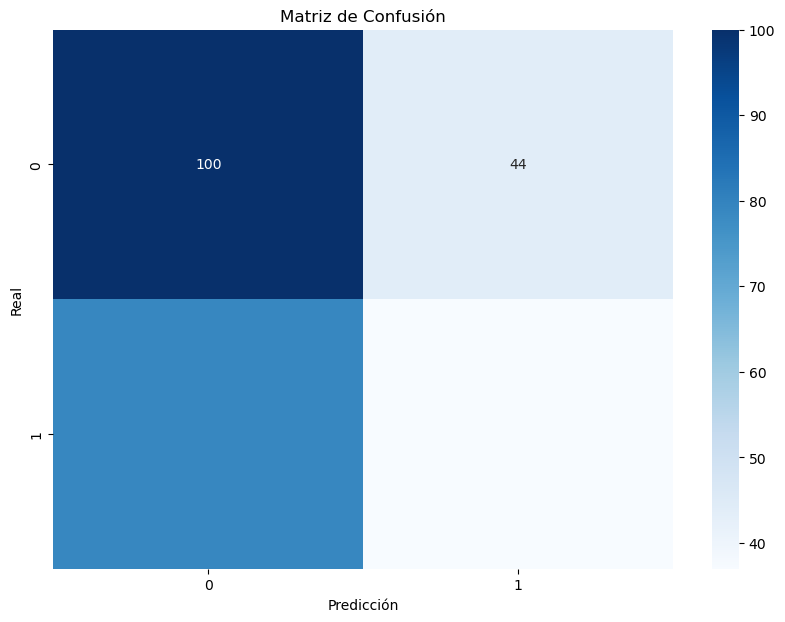

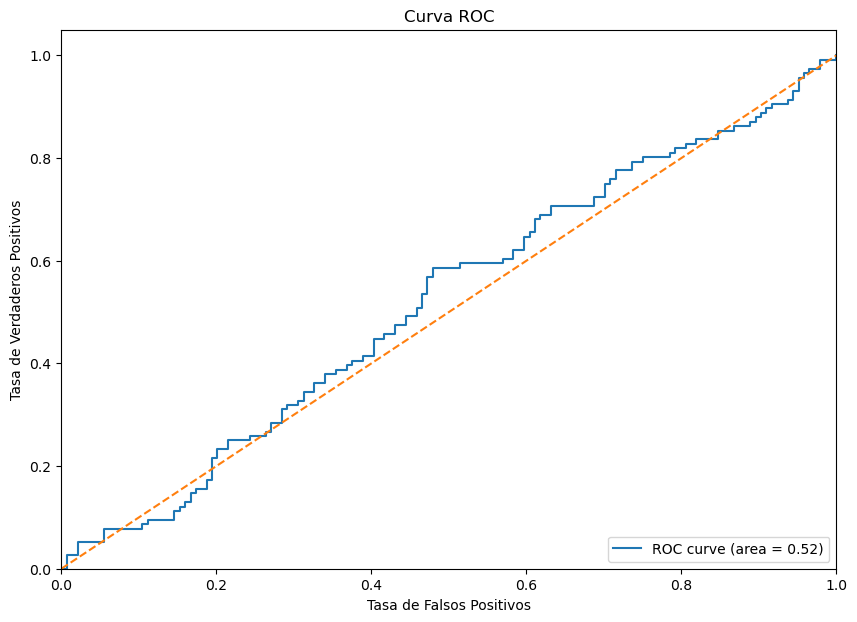

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


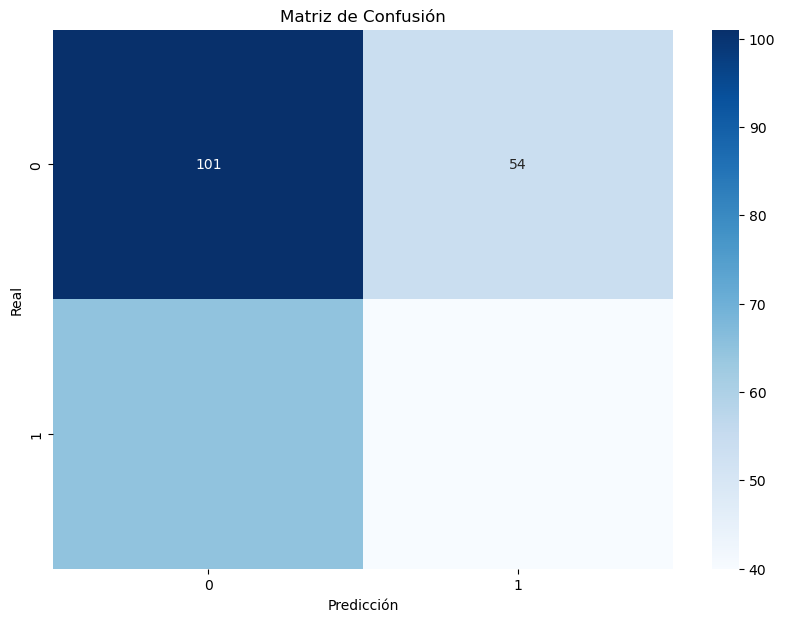

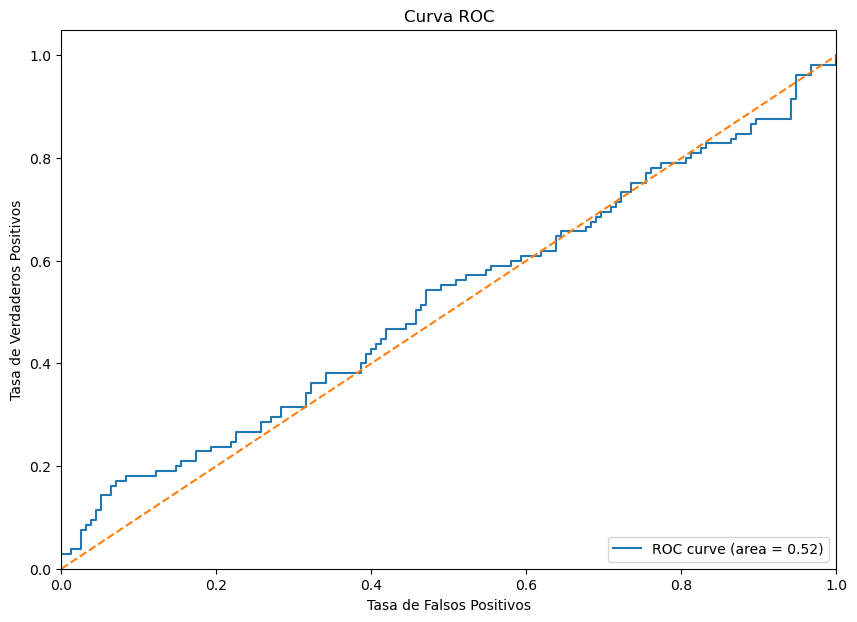

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


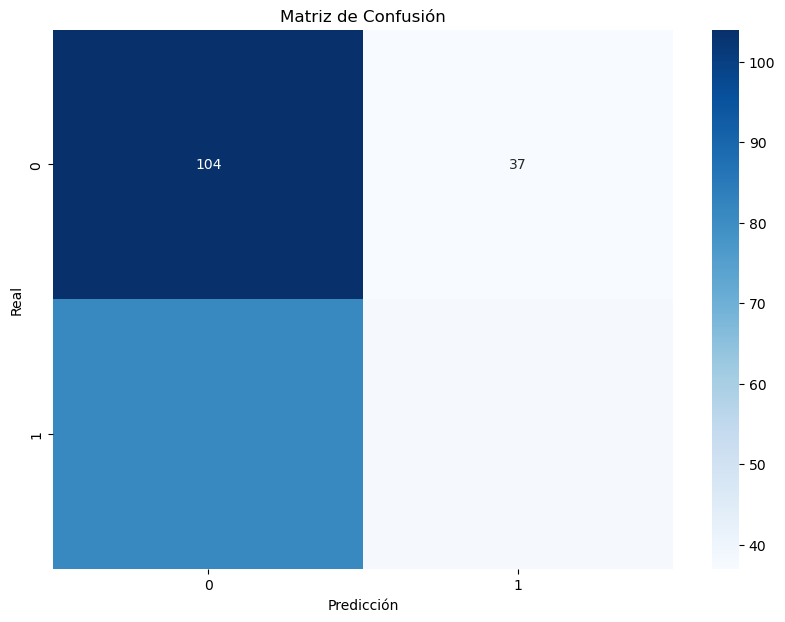

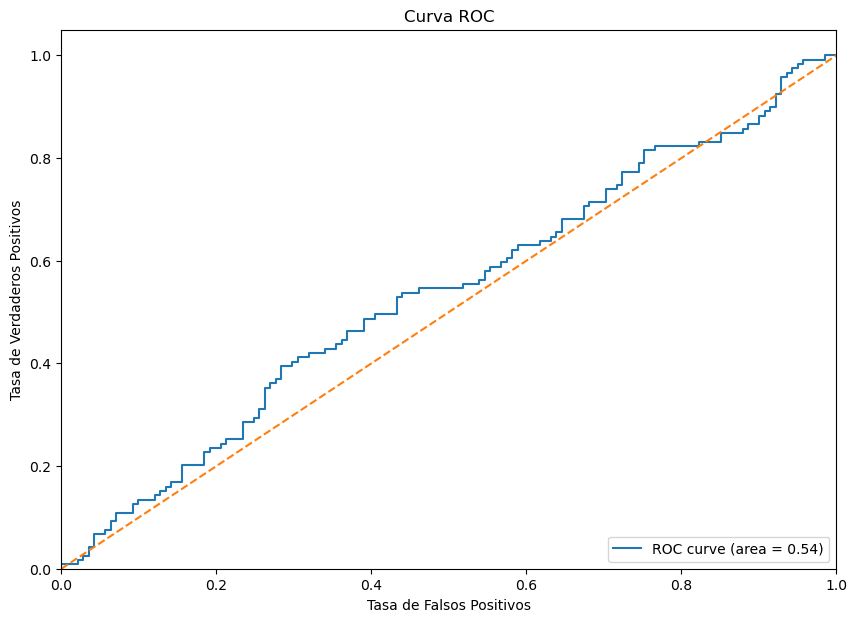

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


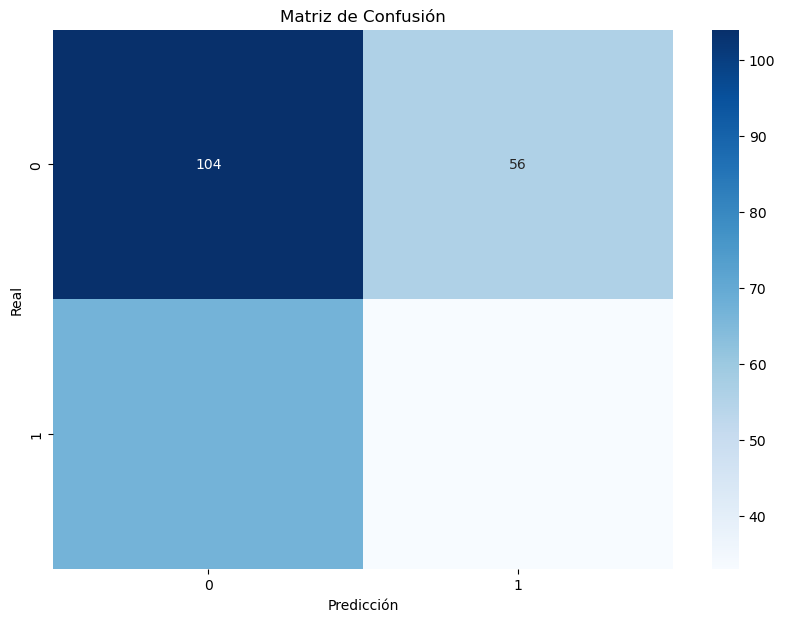

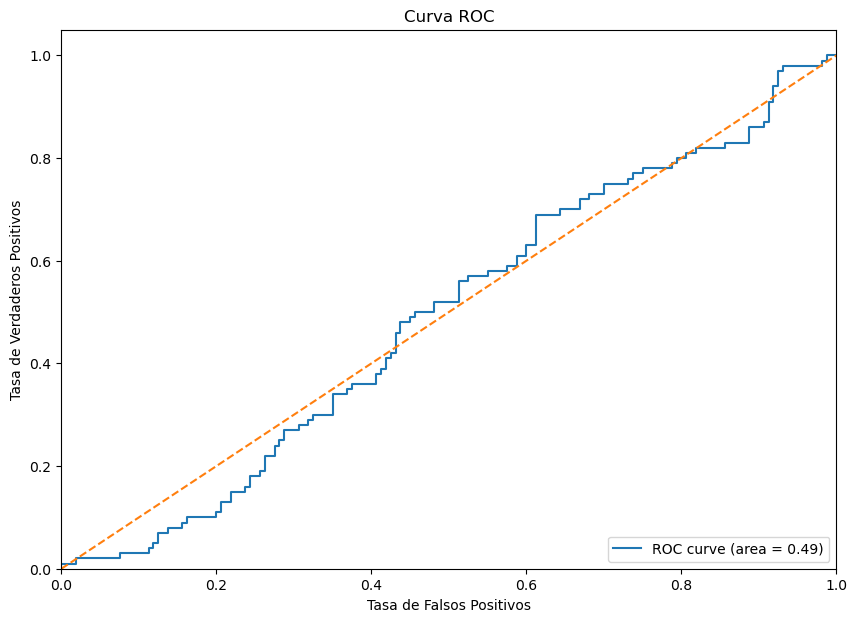

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


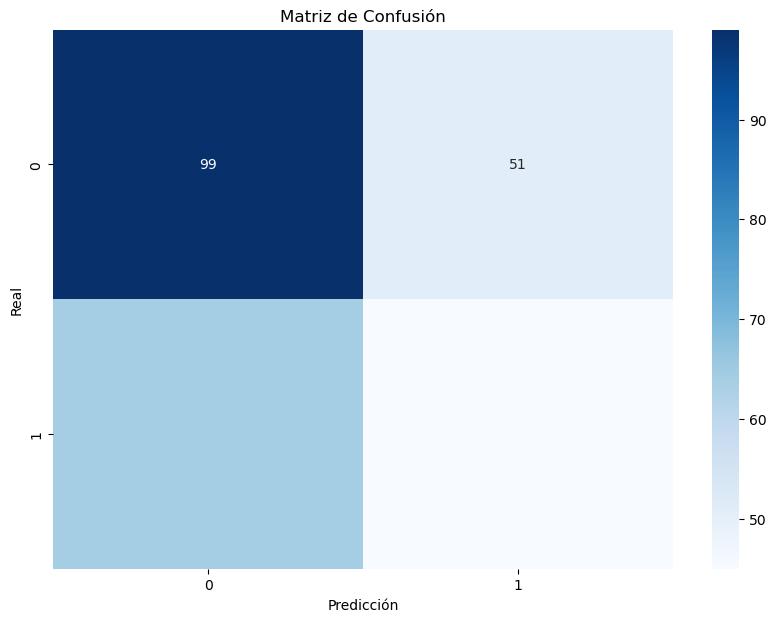

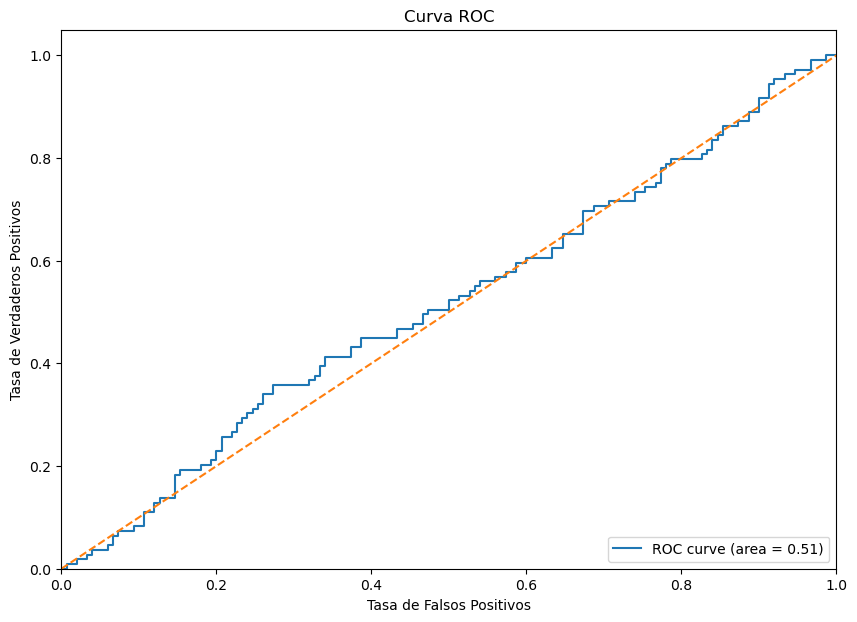

Evaluando configuración: {'C': 100.0}
Error Promedio: 0.4603


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


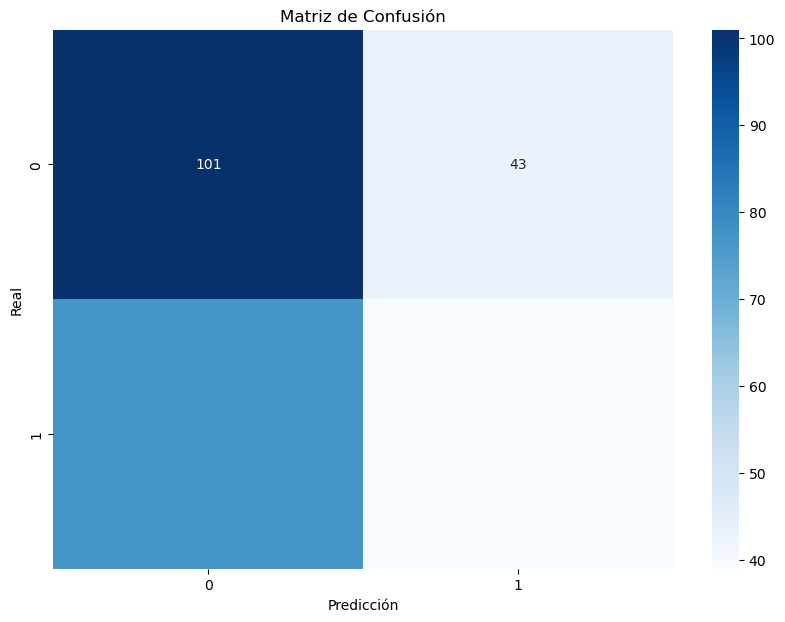

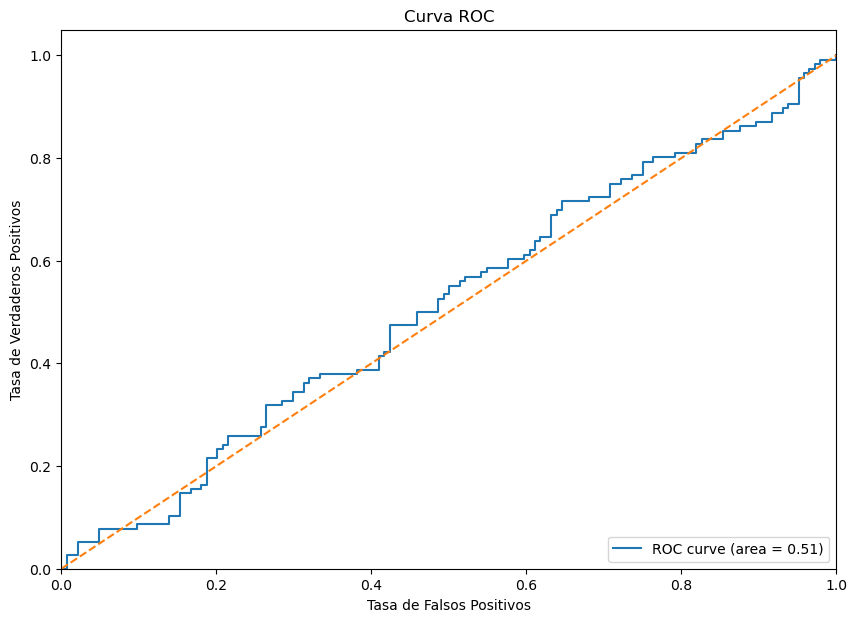

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


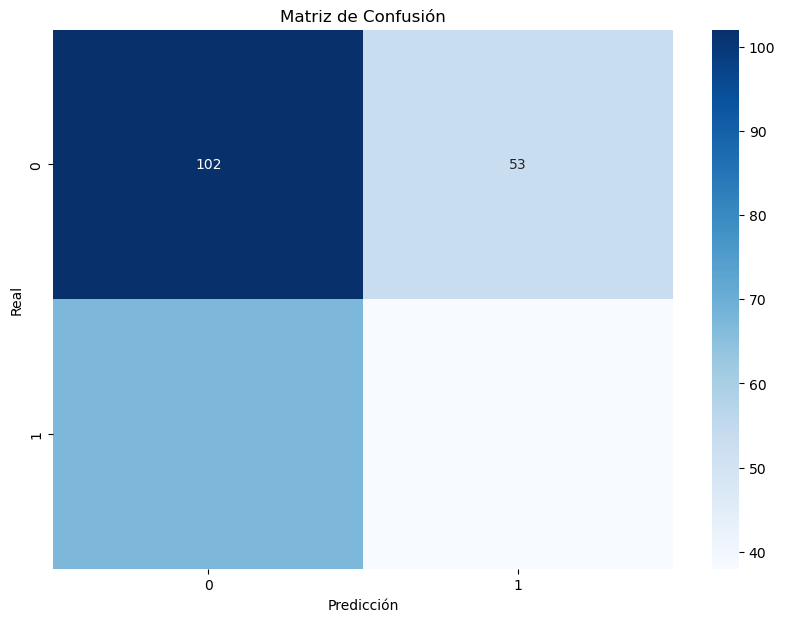

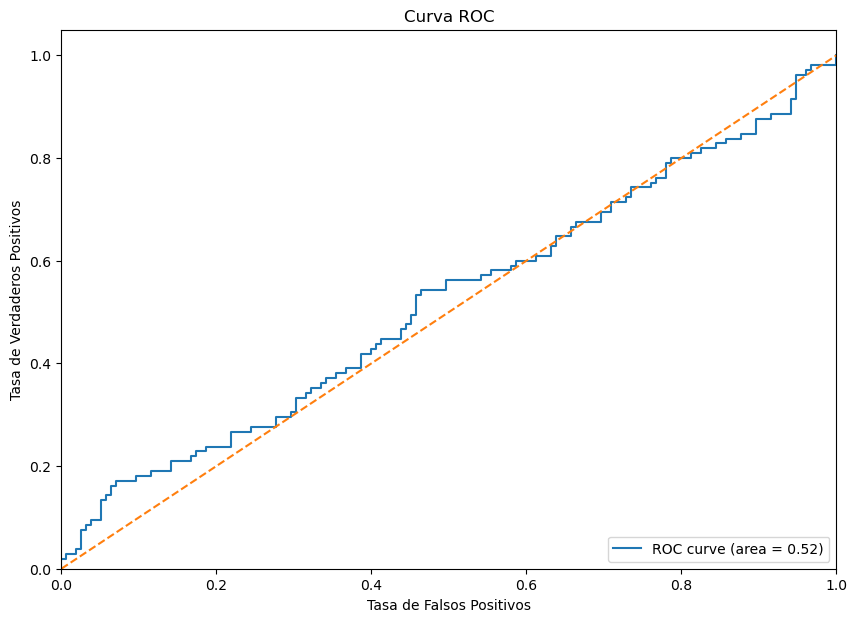

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


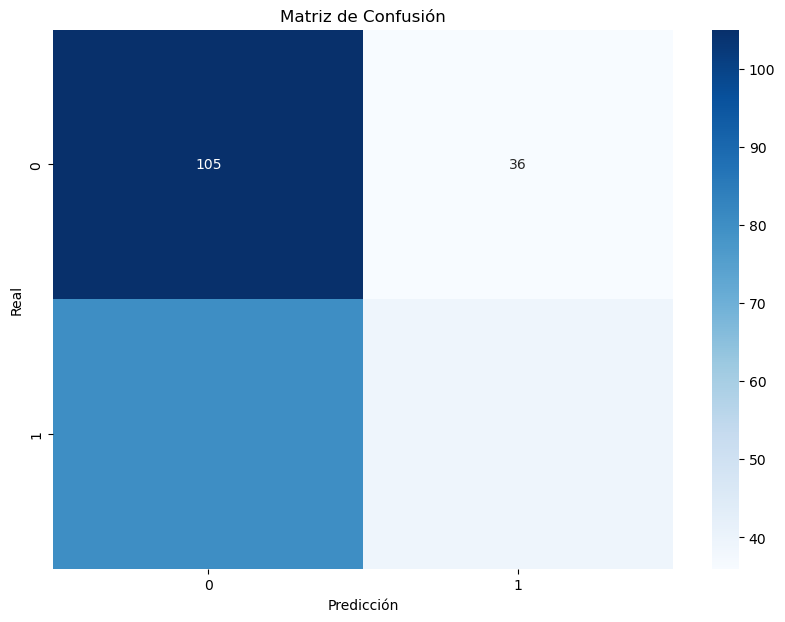

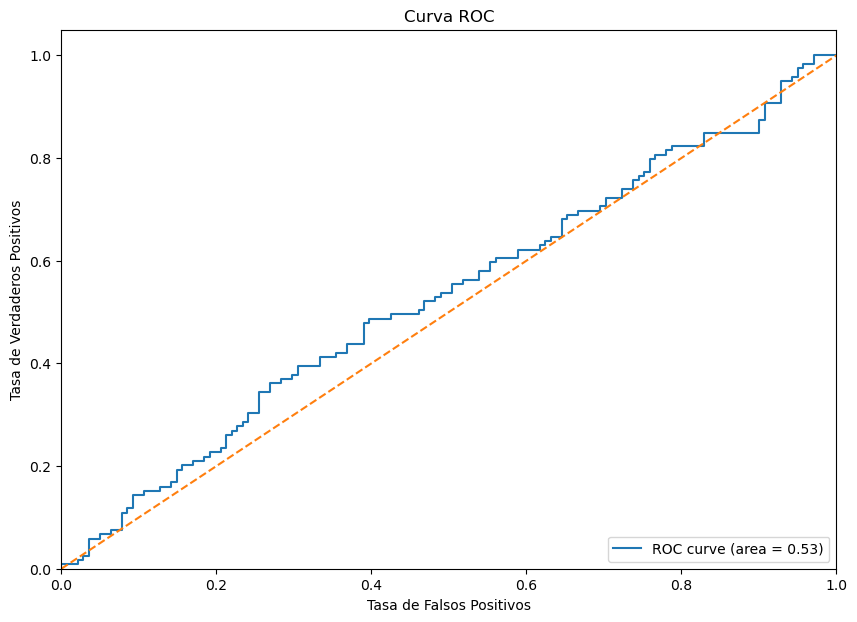

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


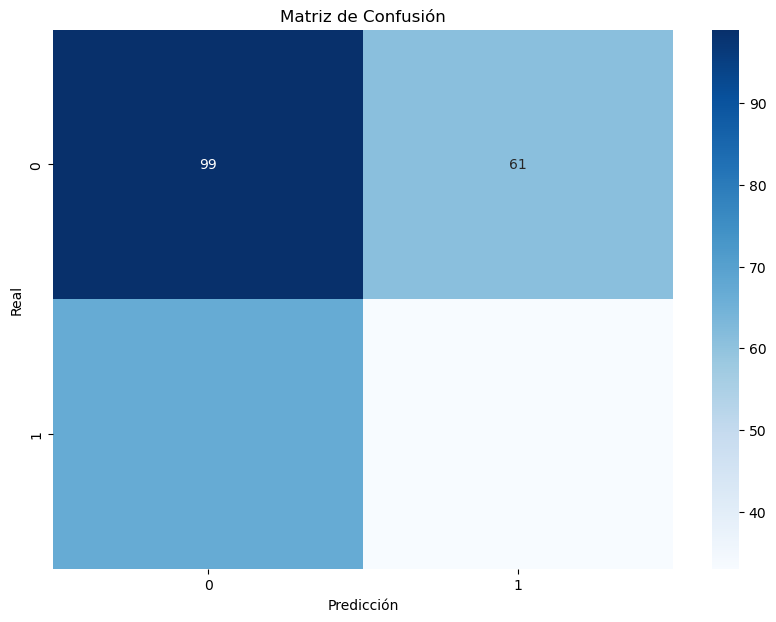

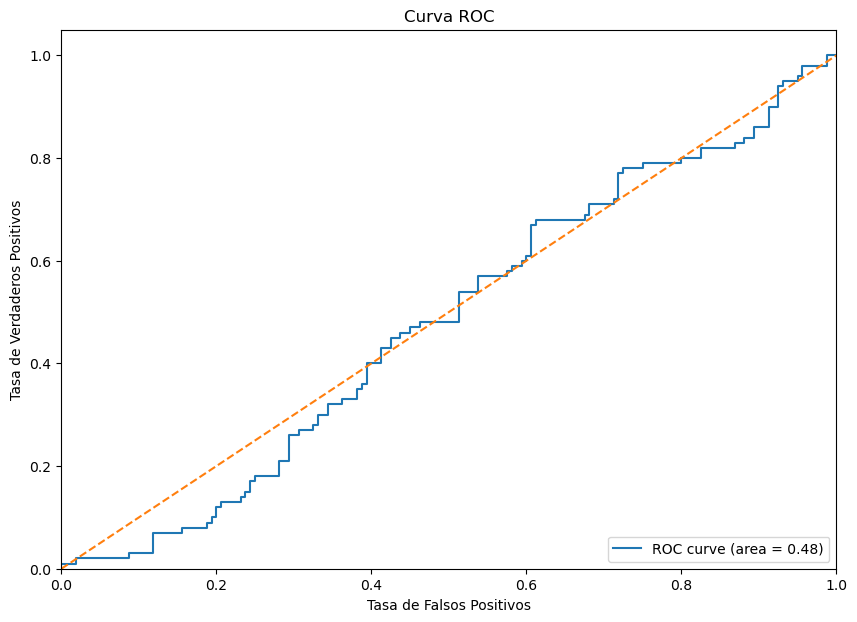

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


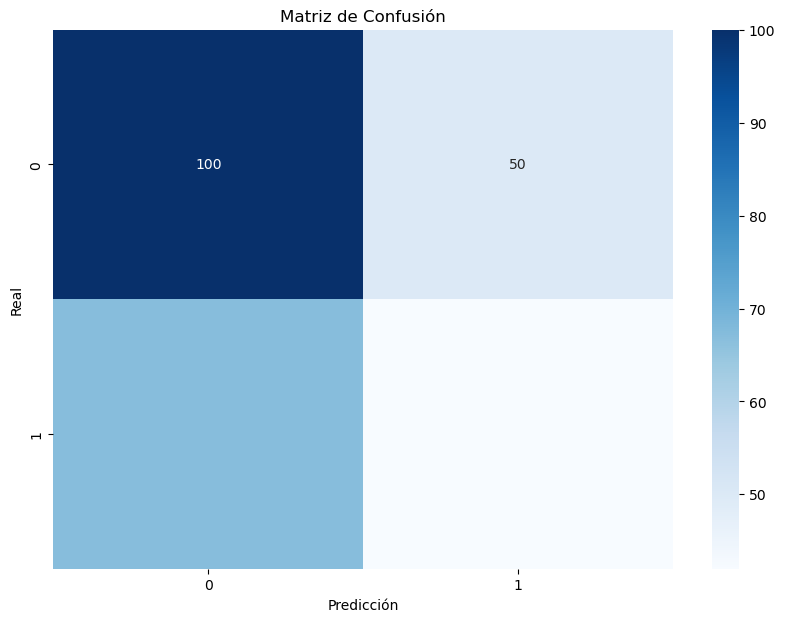

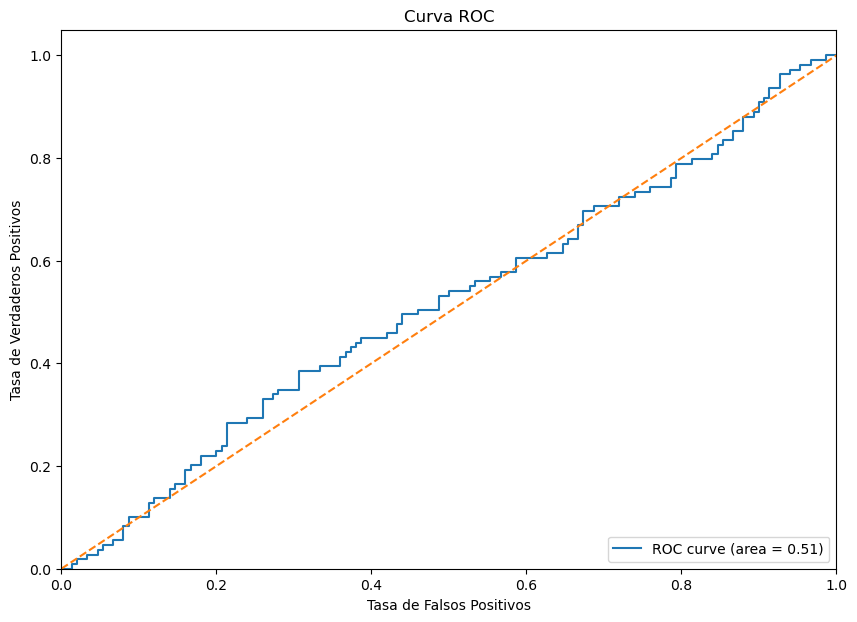

Evaluando configuración: {'C': 10.0}
Error Promedio: 0.4627


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


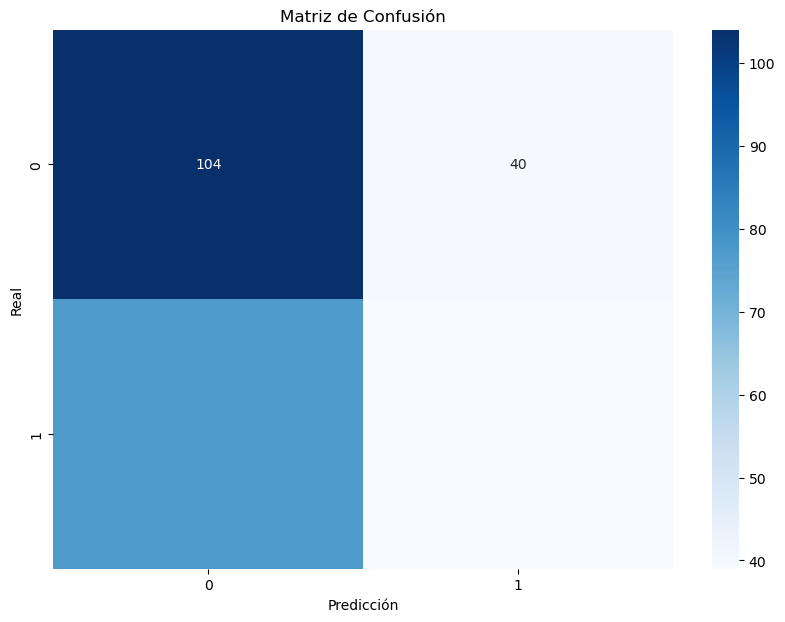

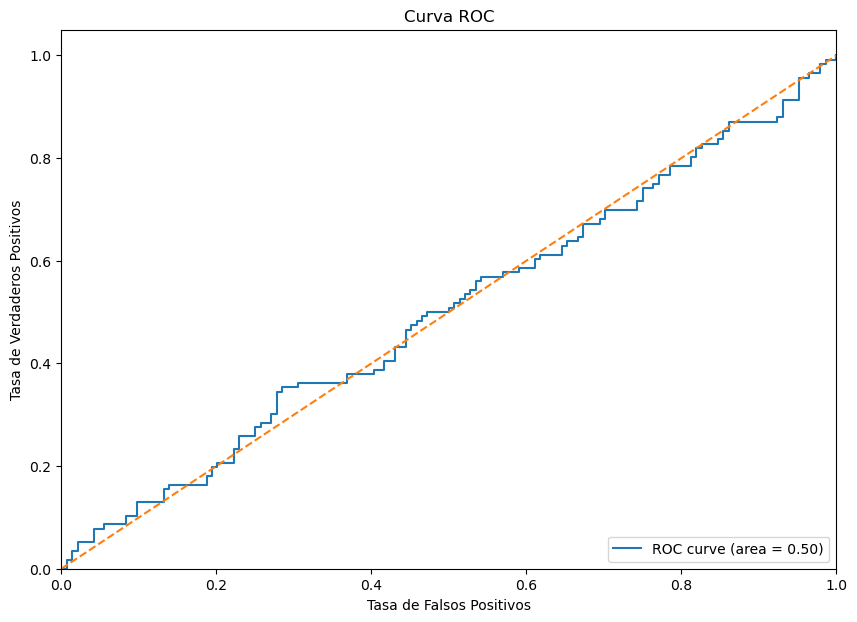

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


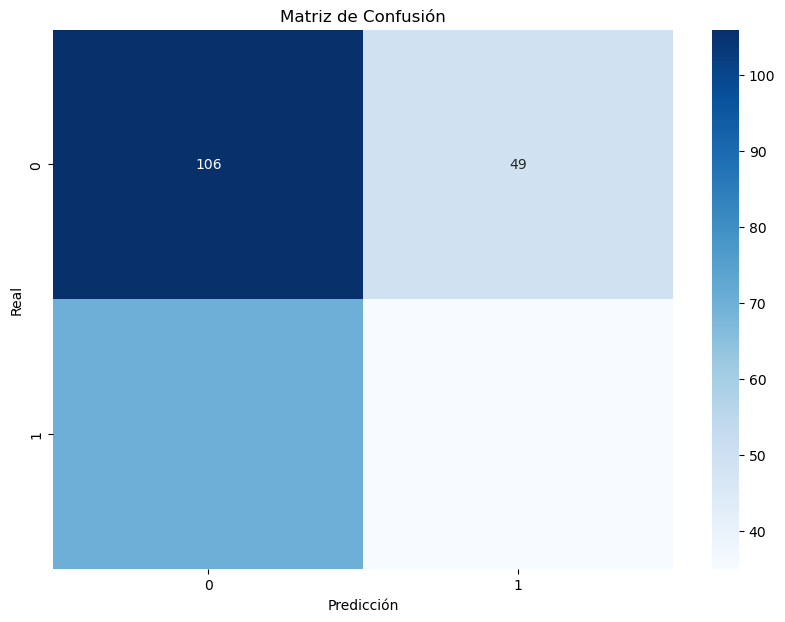

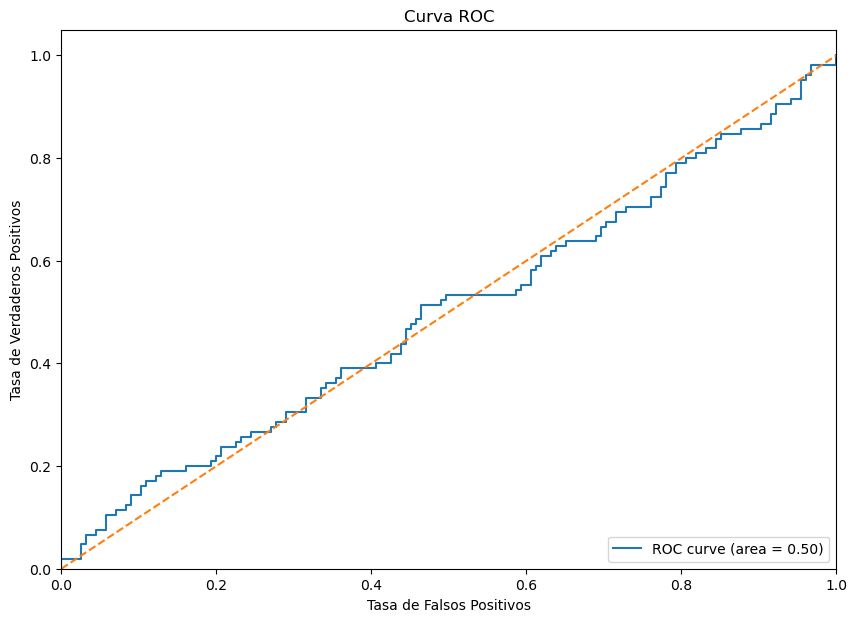

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


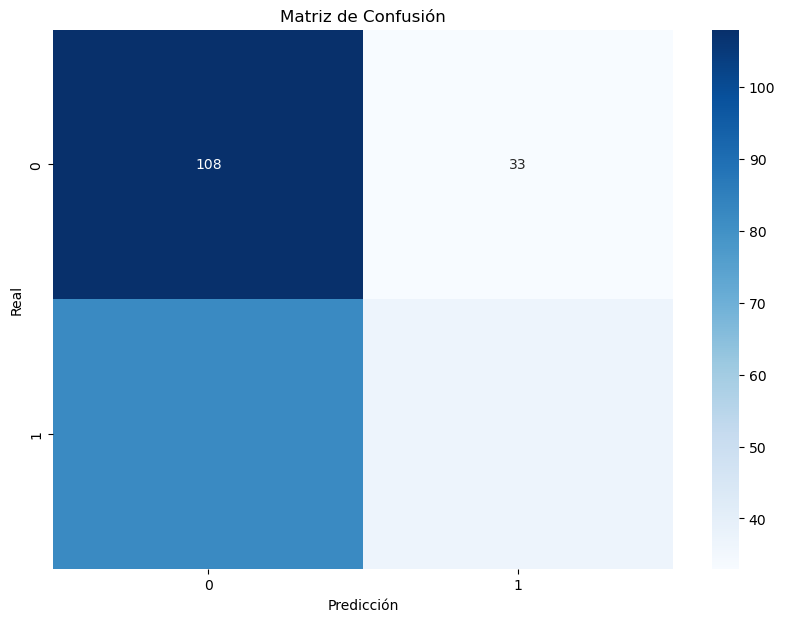

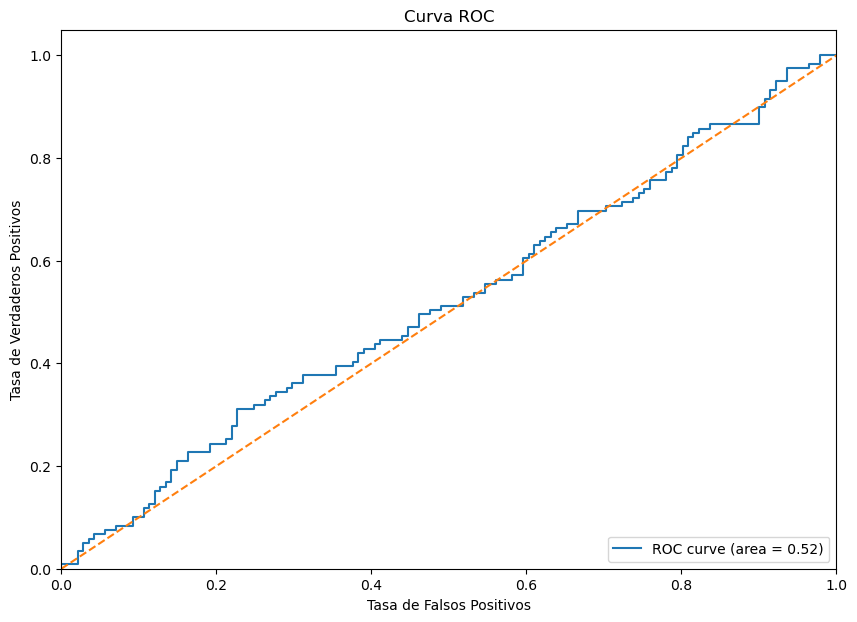

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


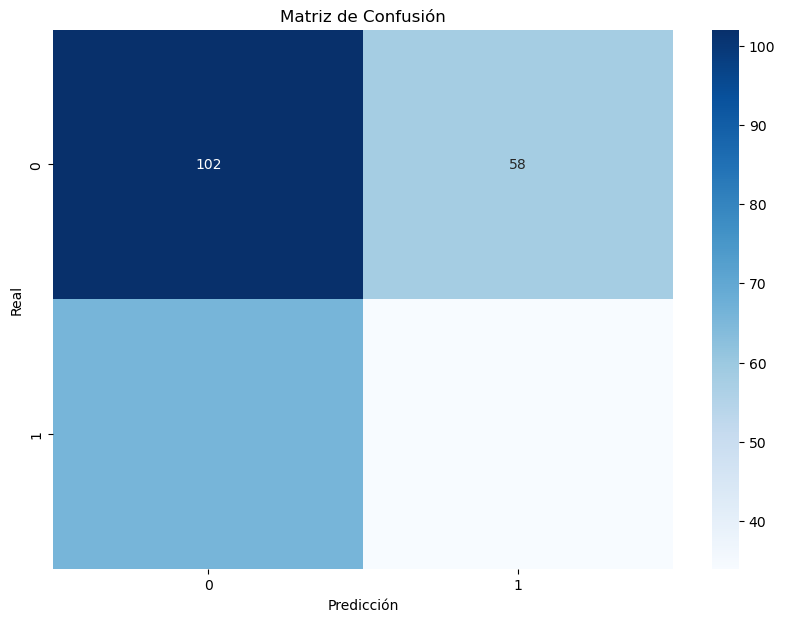

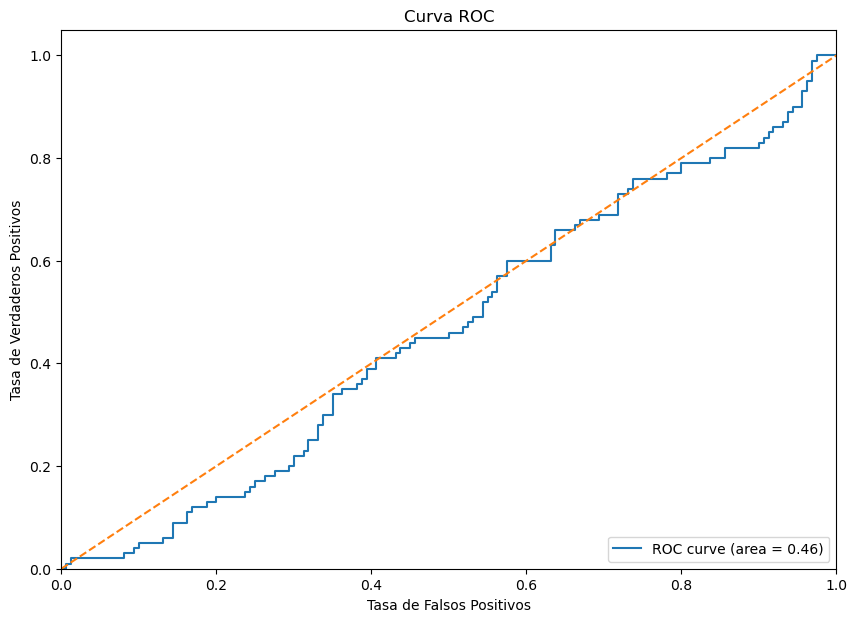

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


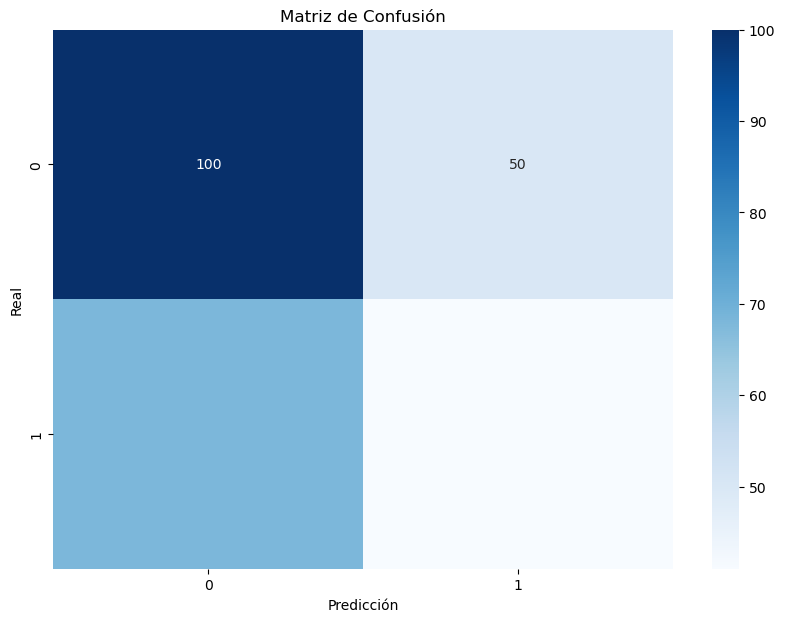

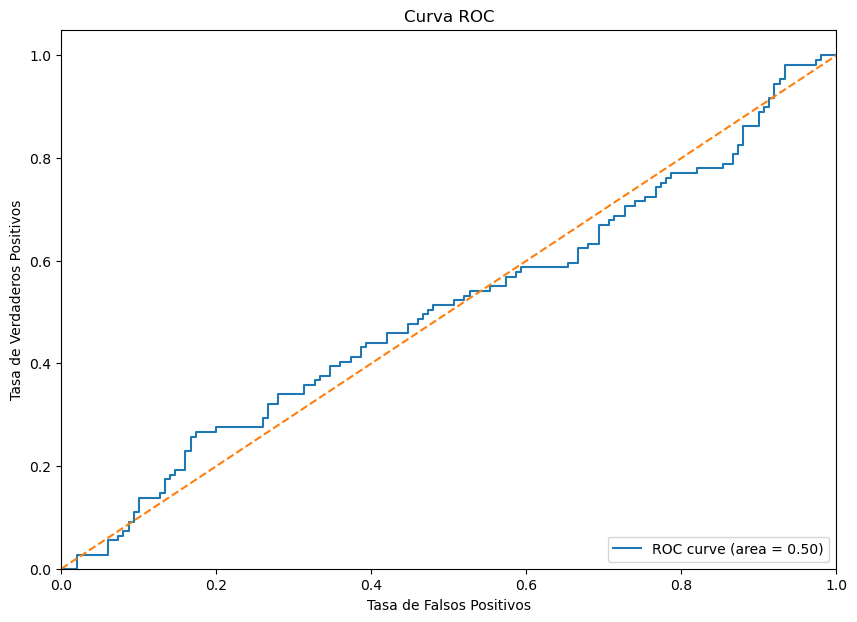

Evaluando configuración: {'C': 1.0}
Error Promedio: 0.4565


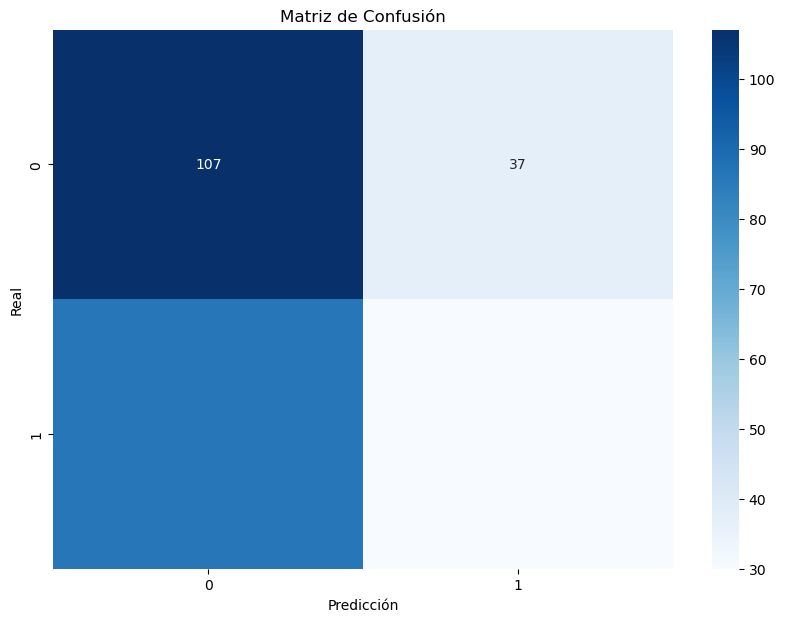

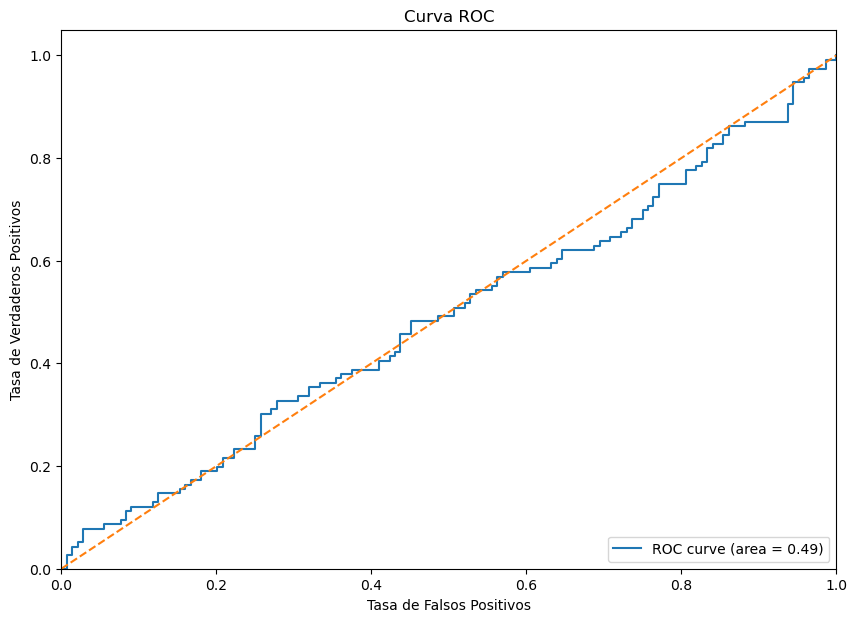

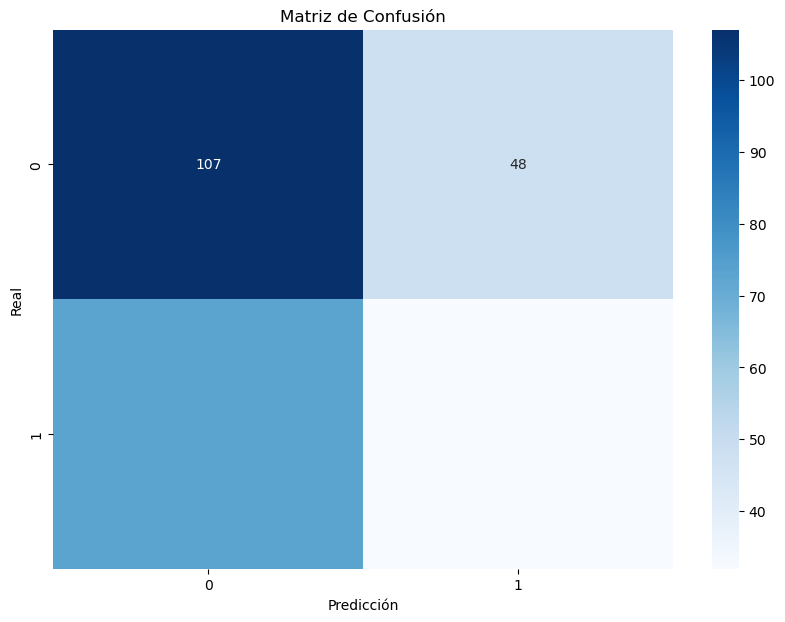

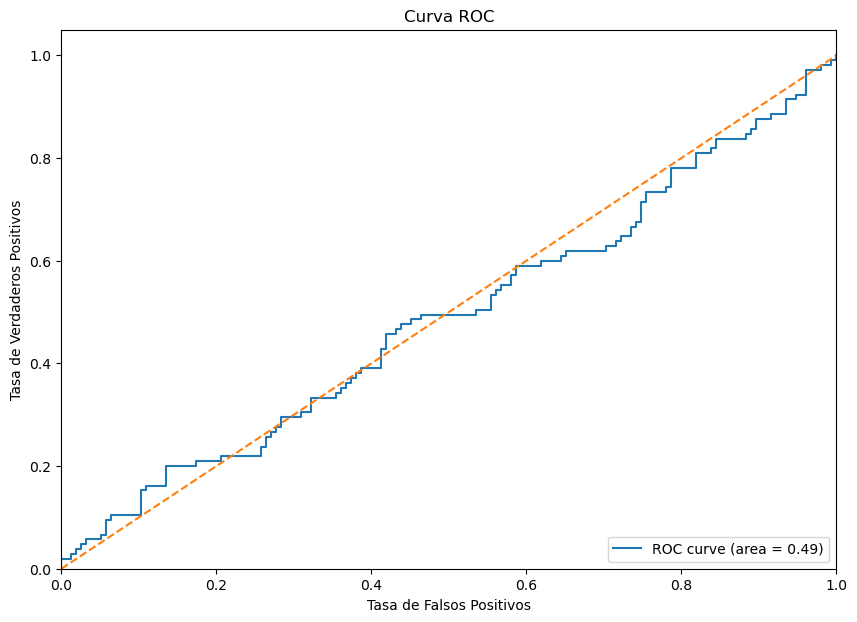

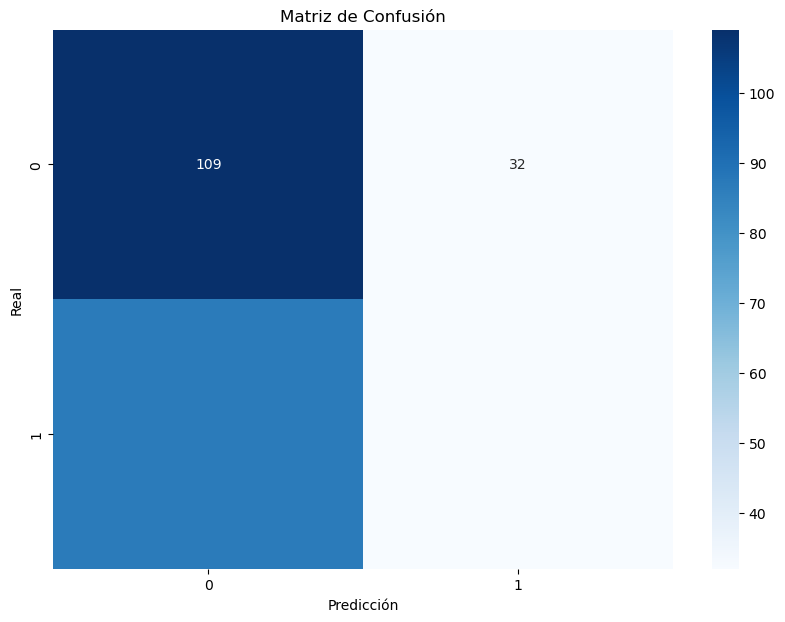

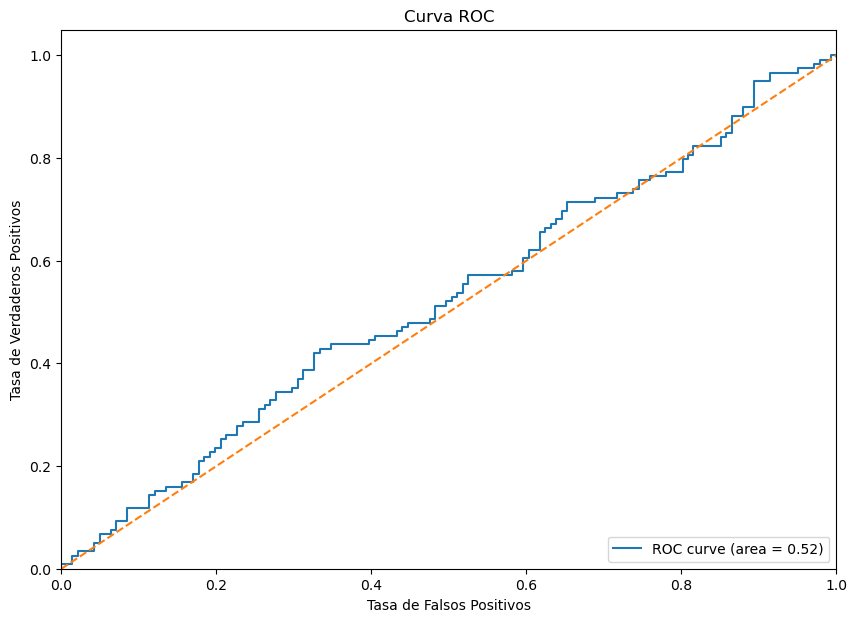

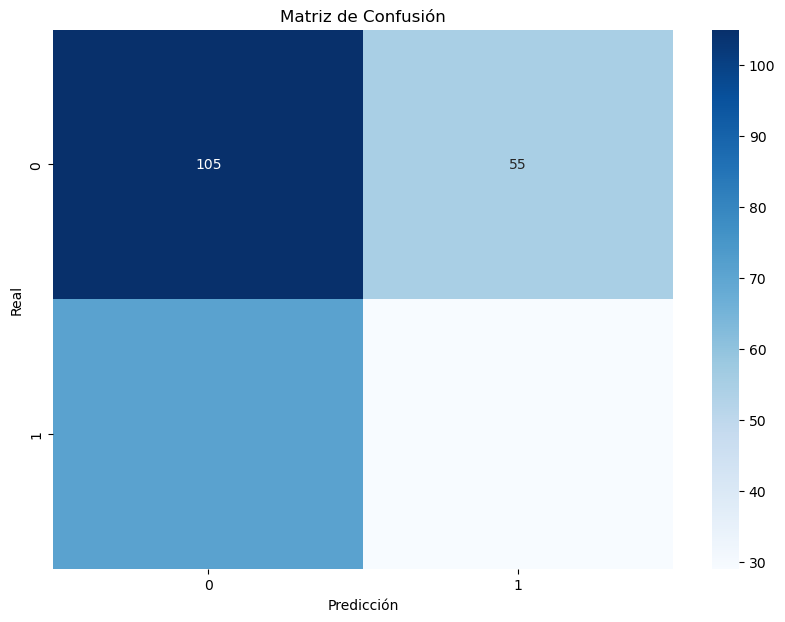

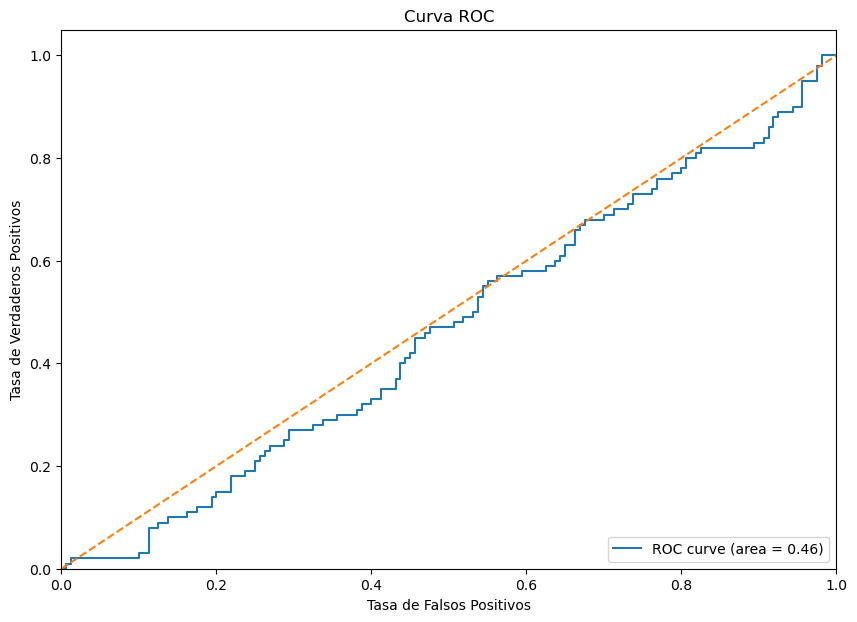

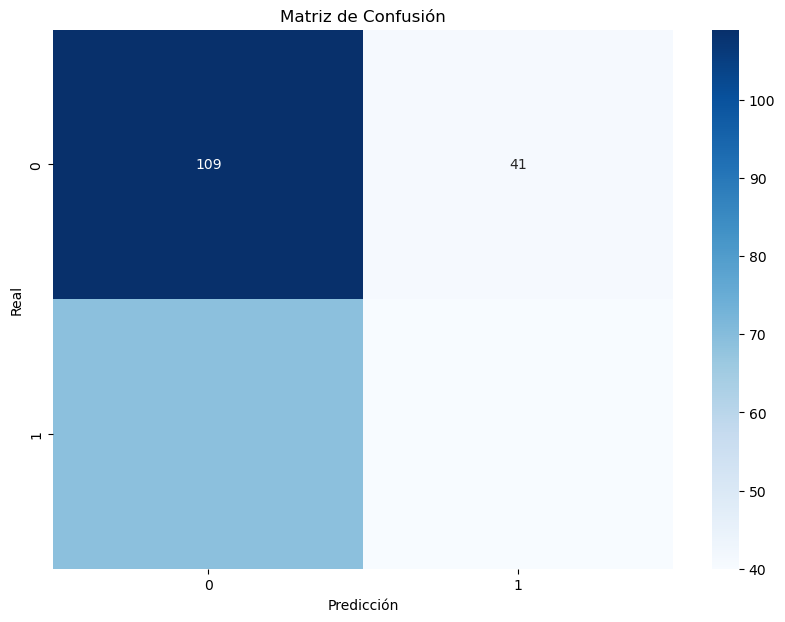

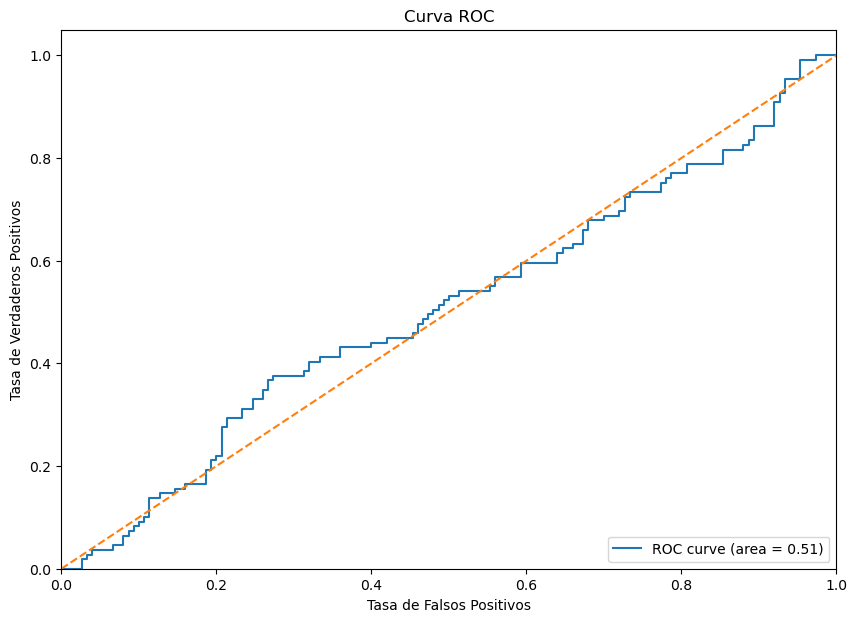

Evaluando configuración: {'C': 0.1}
Error Promedio: 0.4611


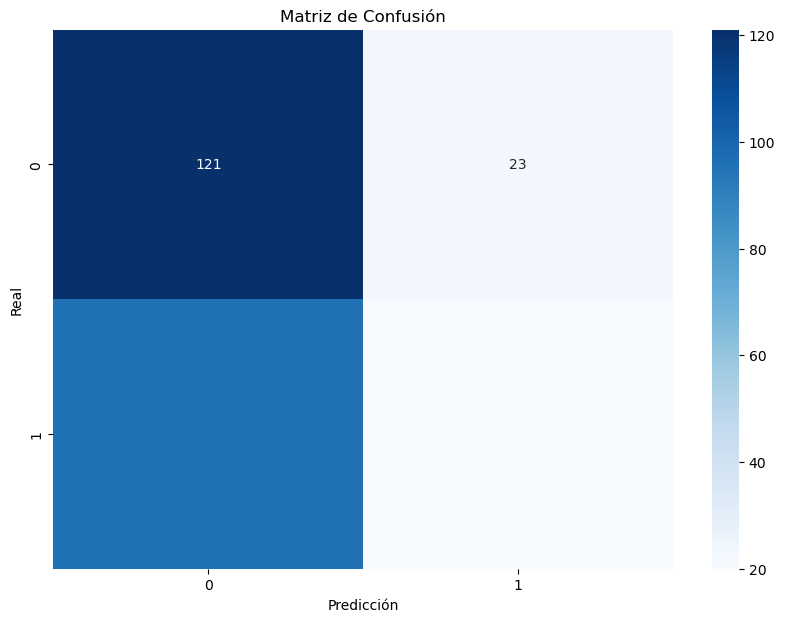

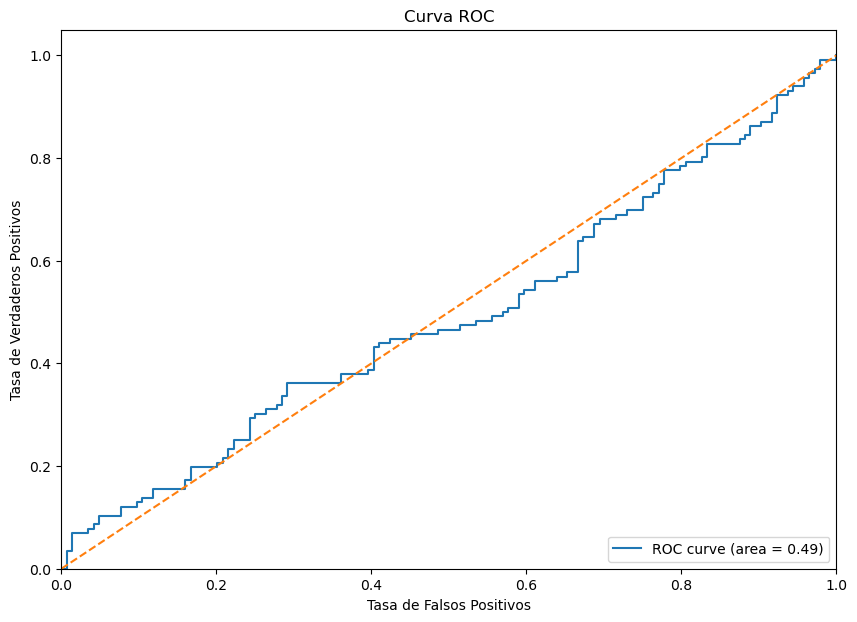

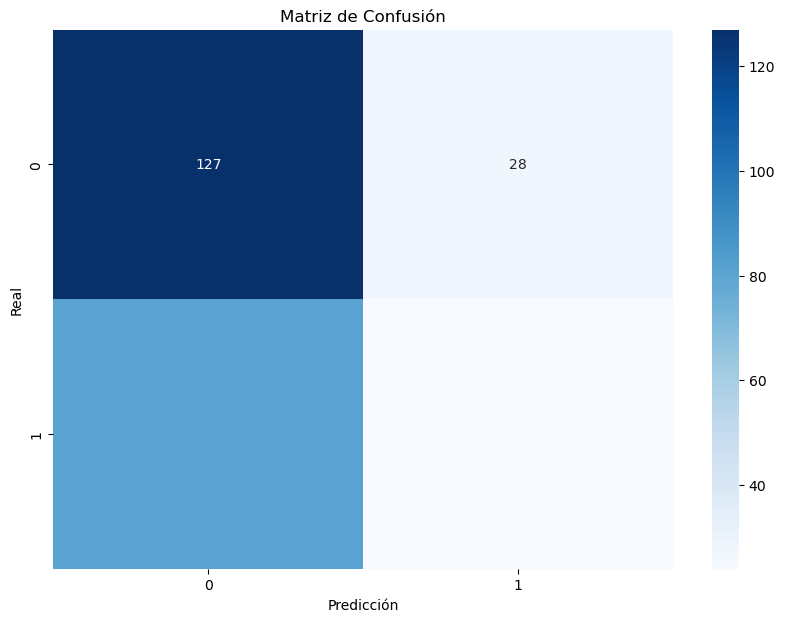

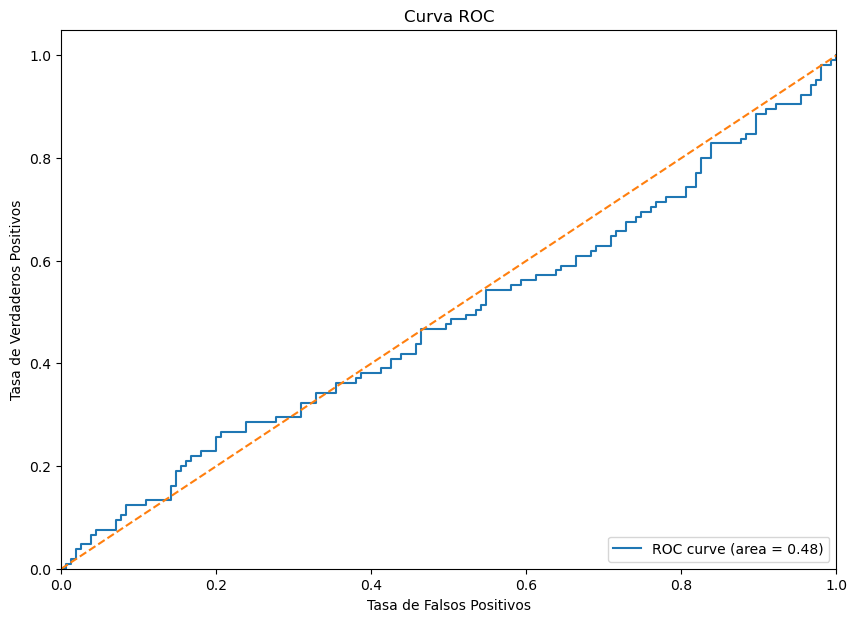

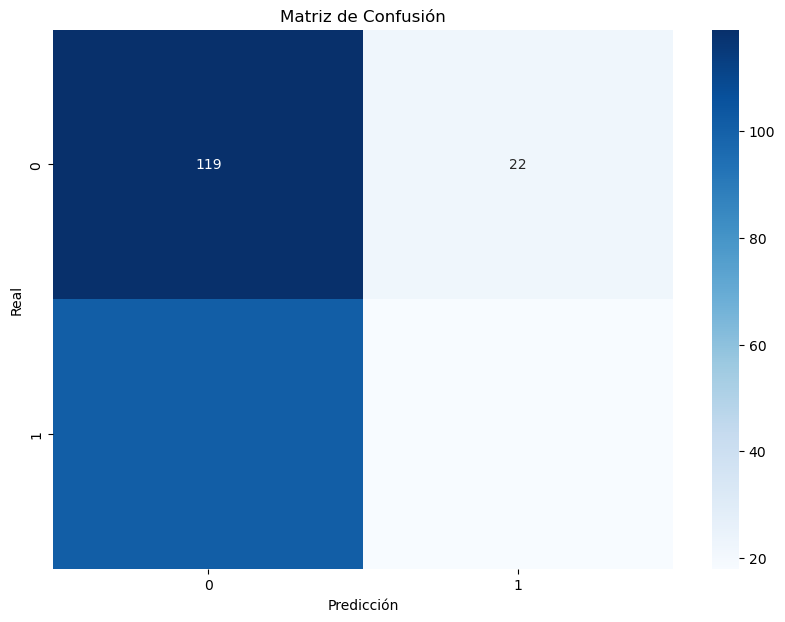

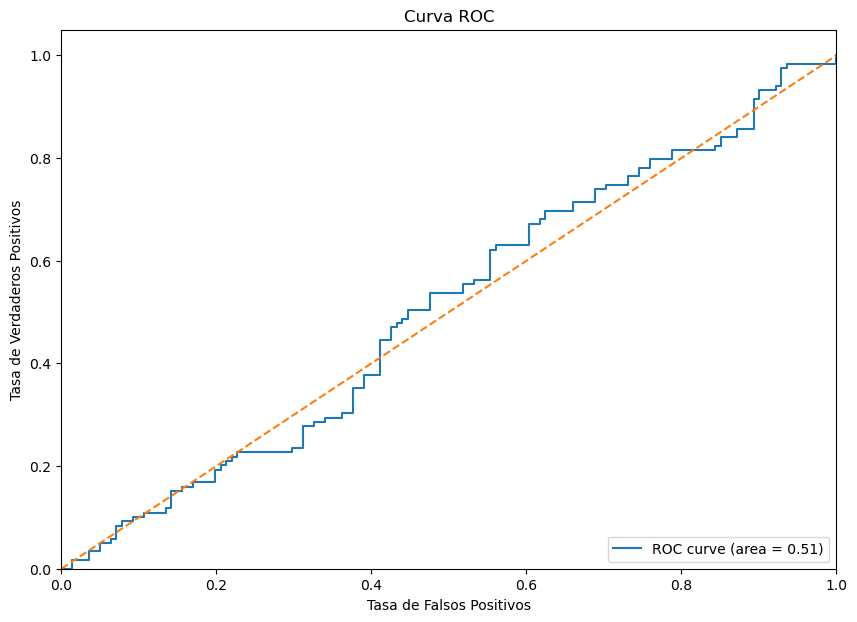

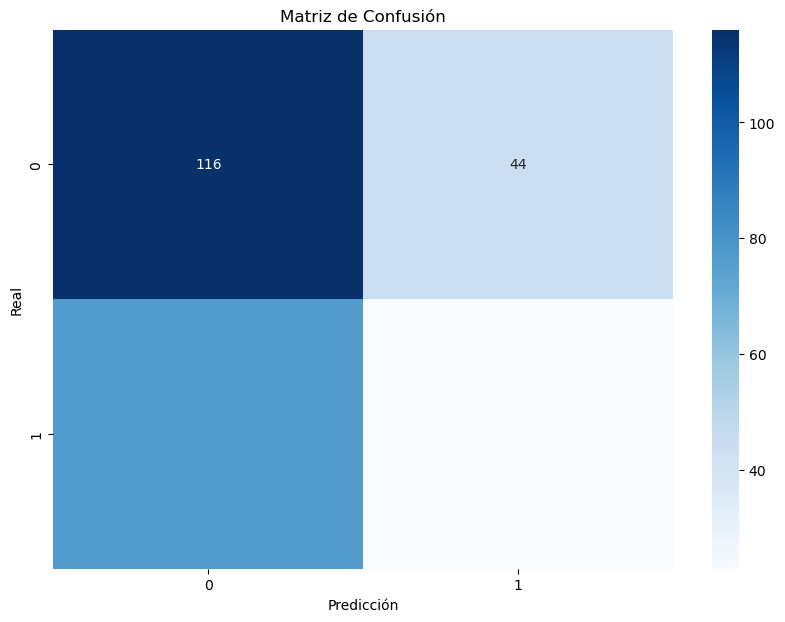

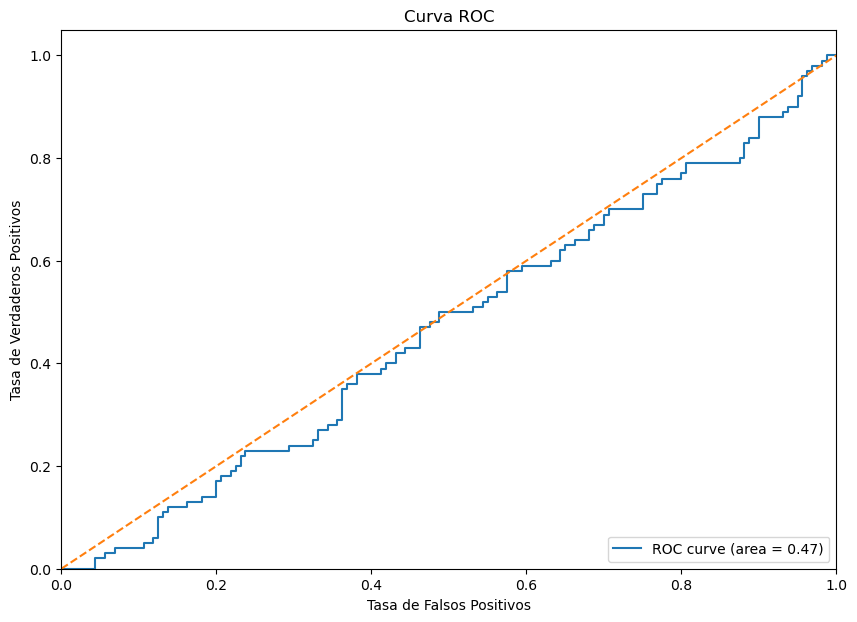

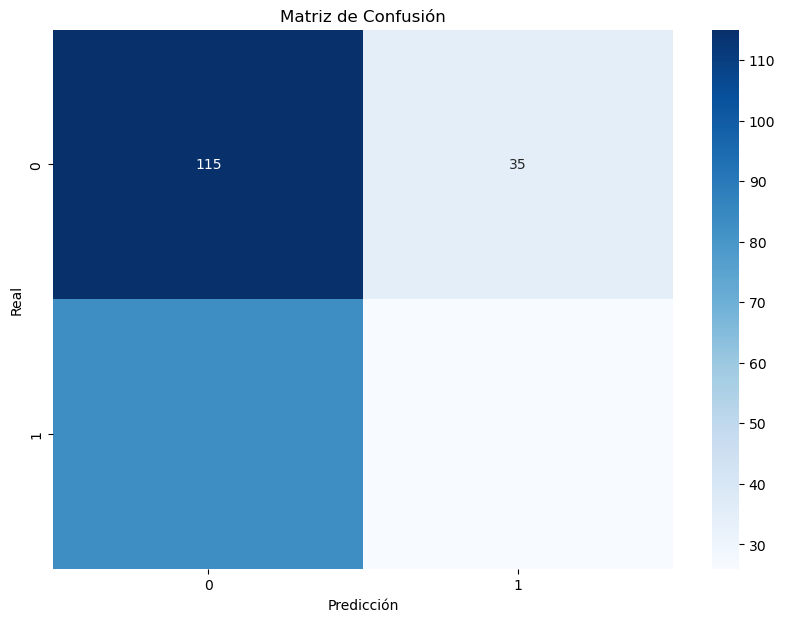

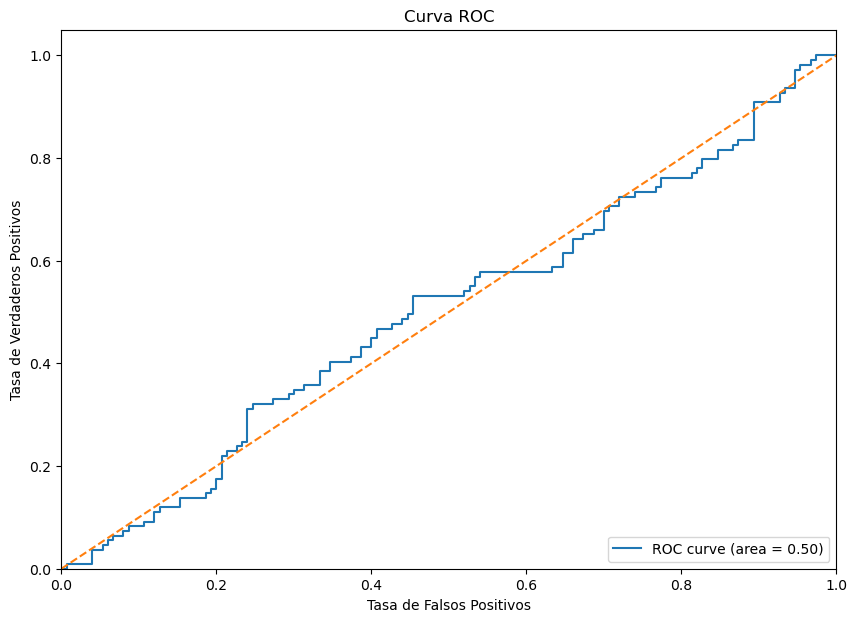

Evaluando configuración: {'C': 0.01}
Error Promedio: 0.4542


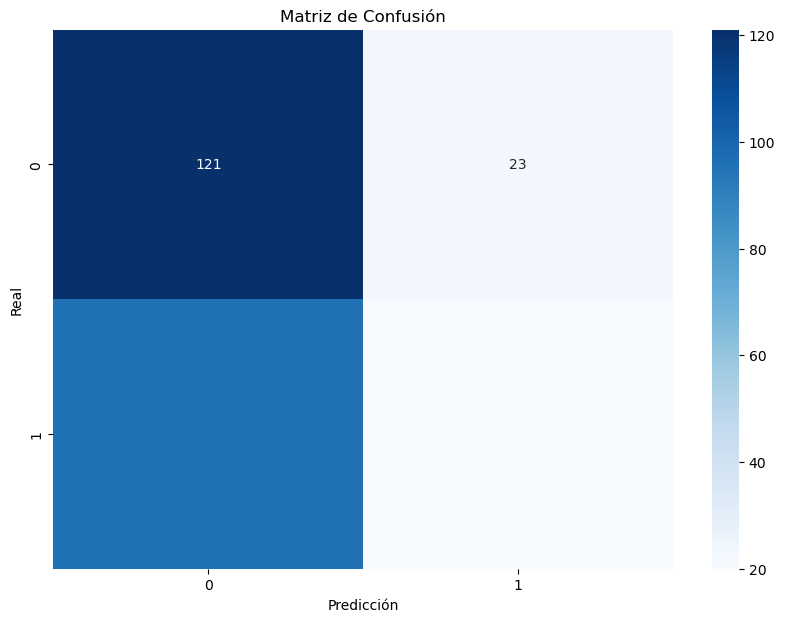

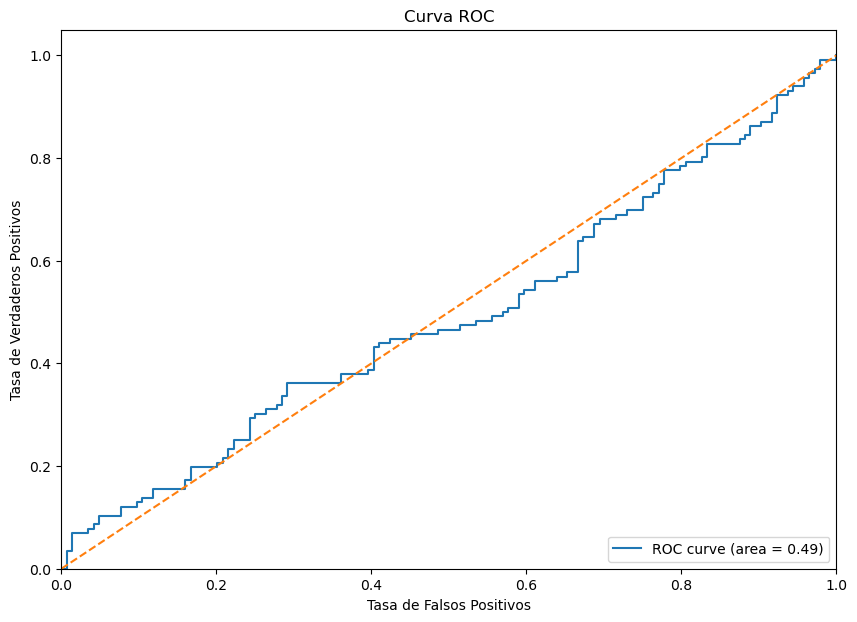

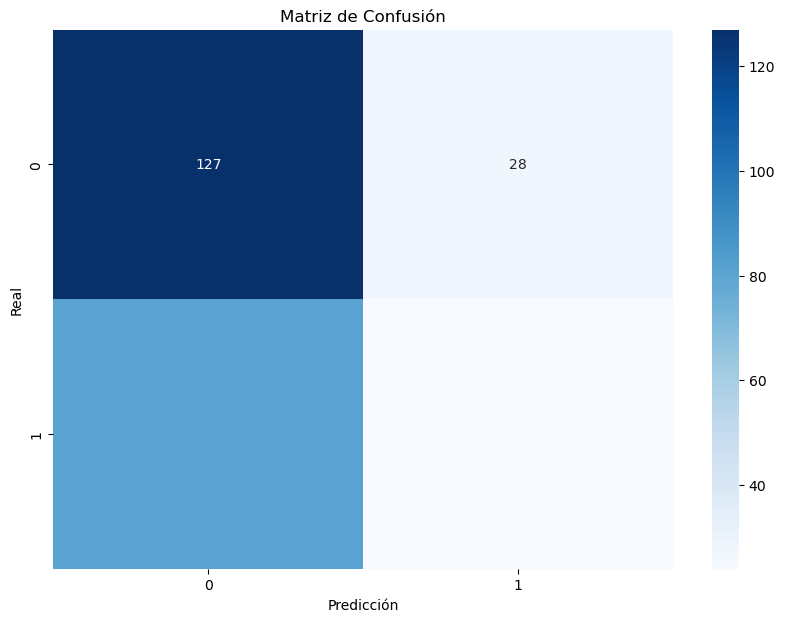

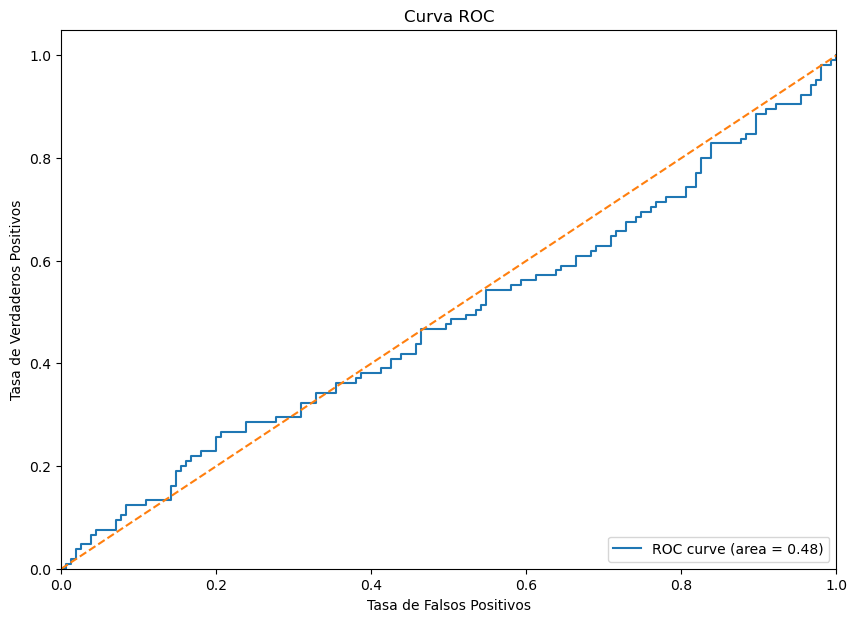

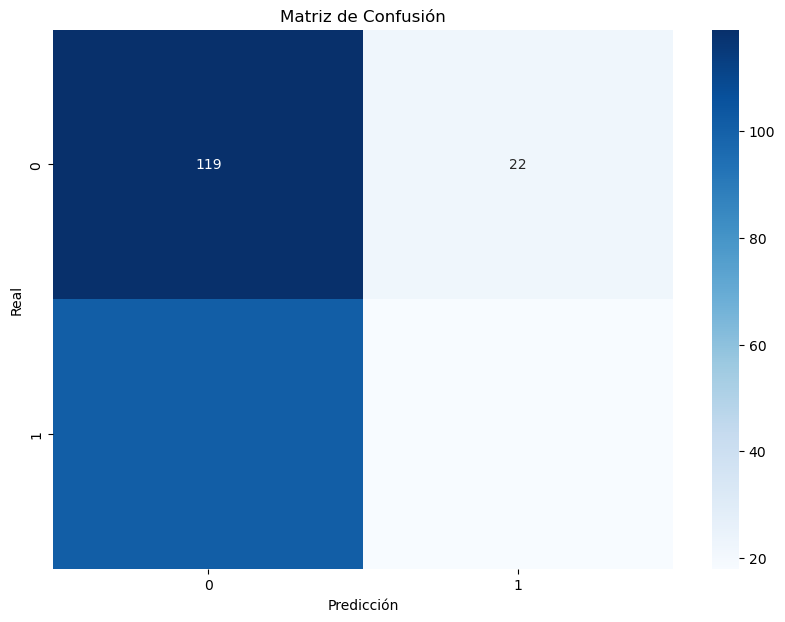

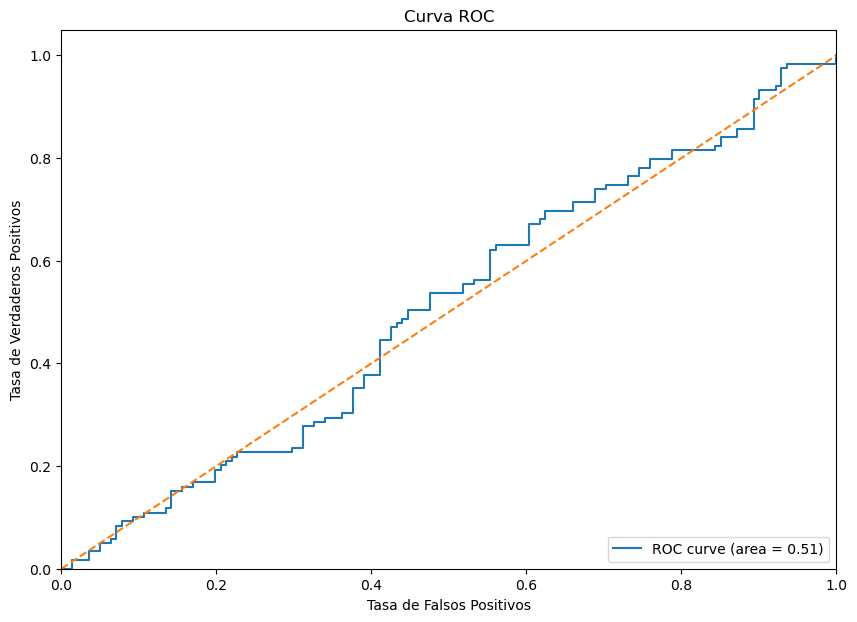

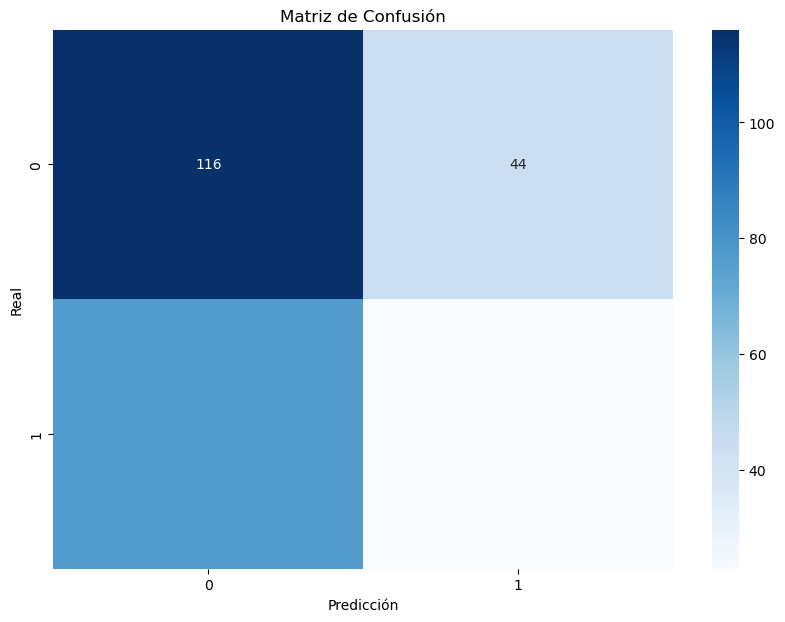

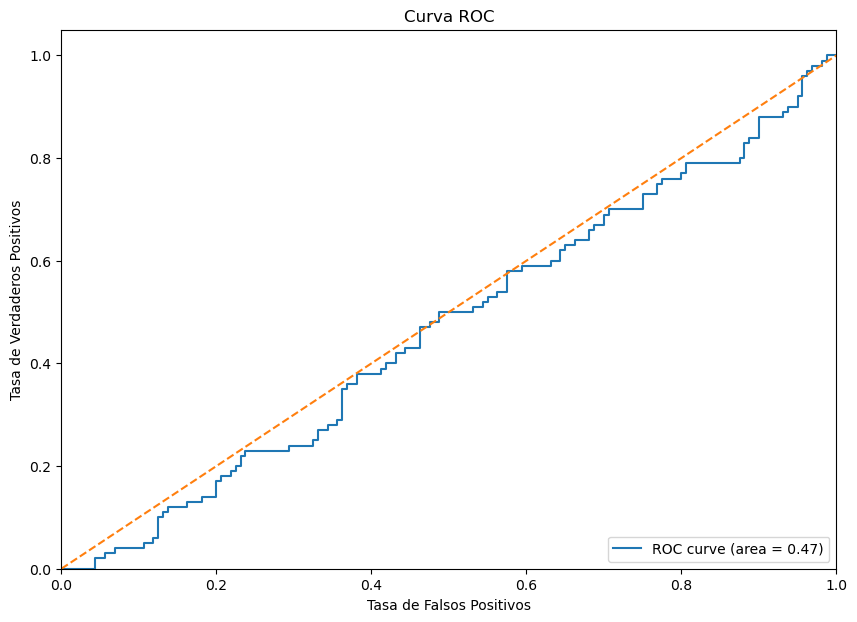

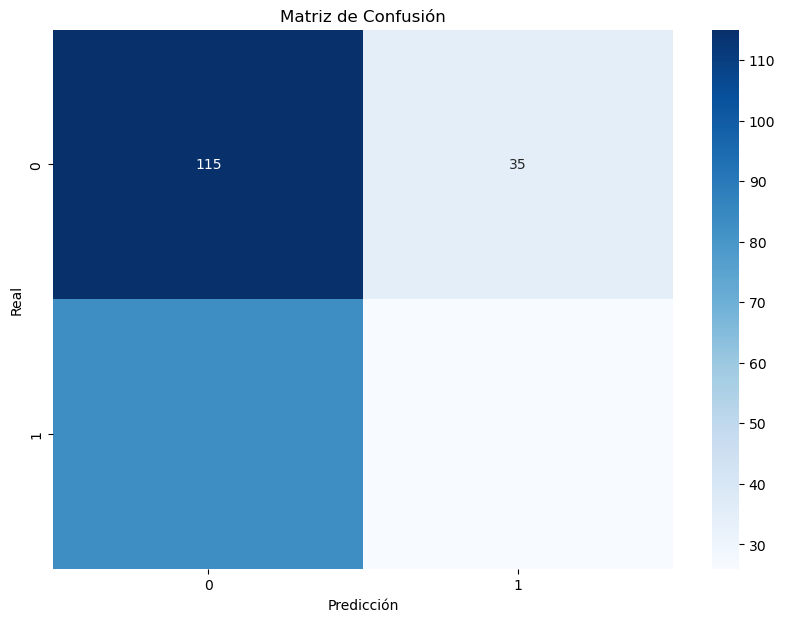

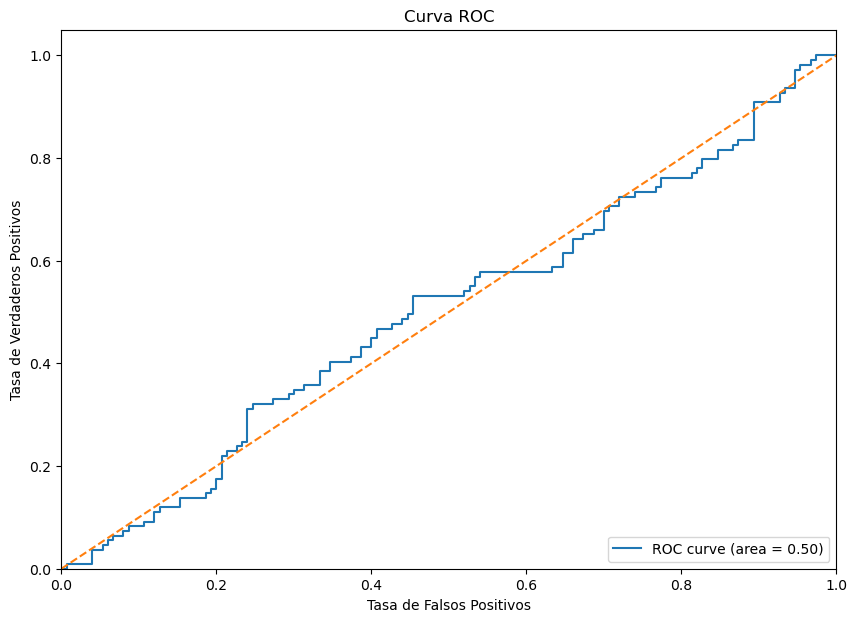

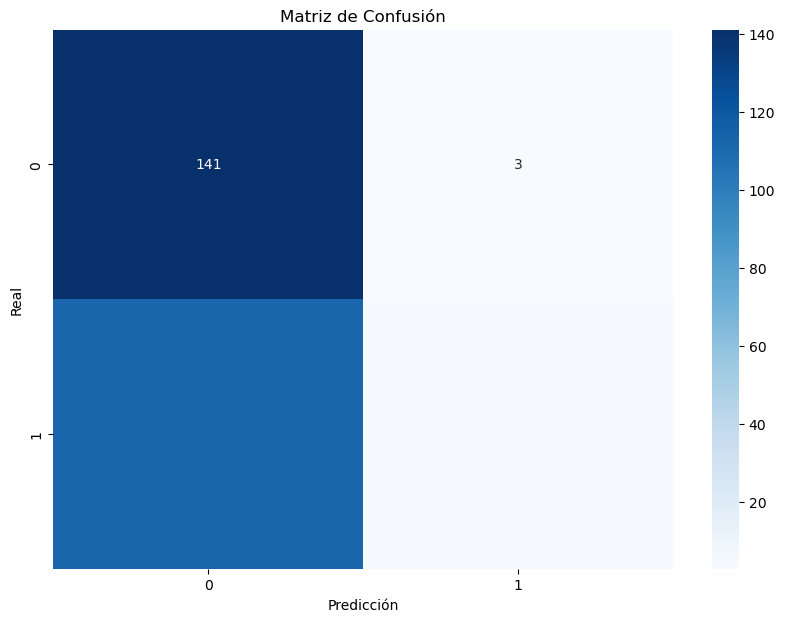

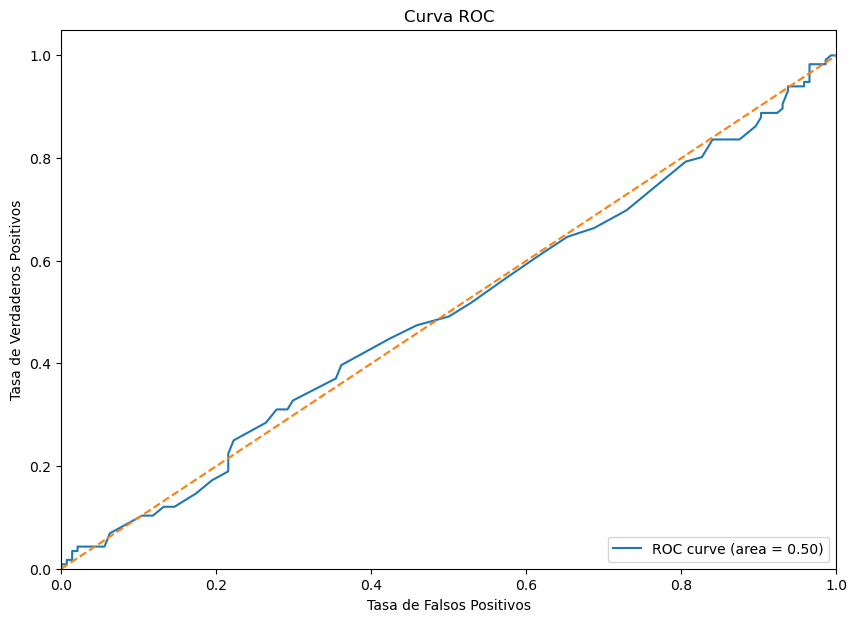

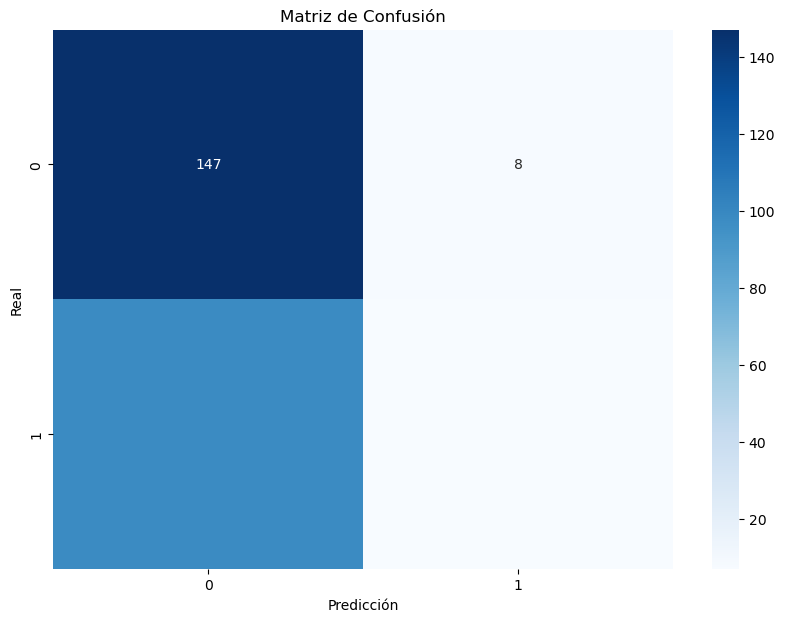

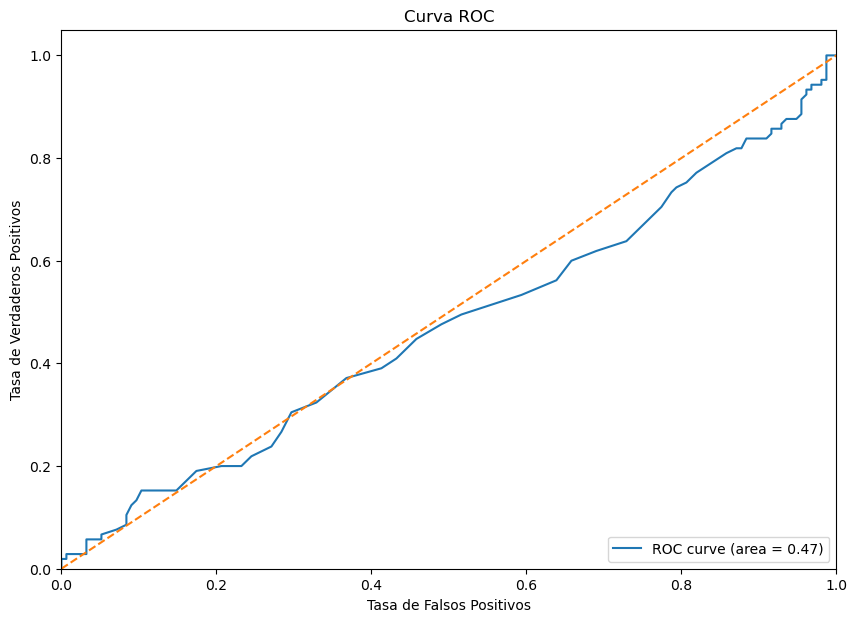

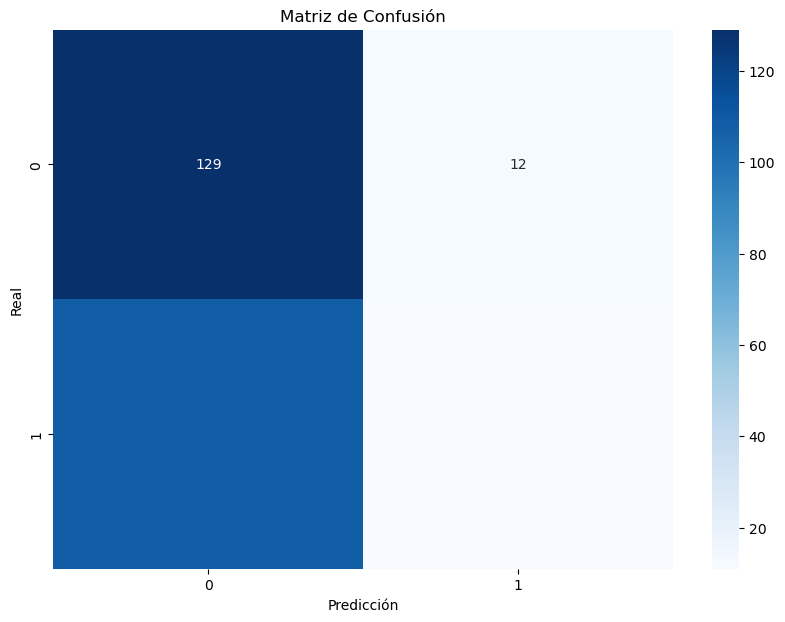

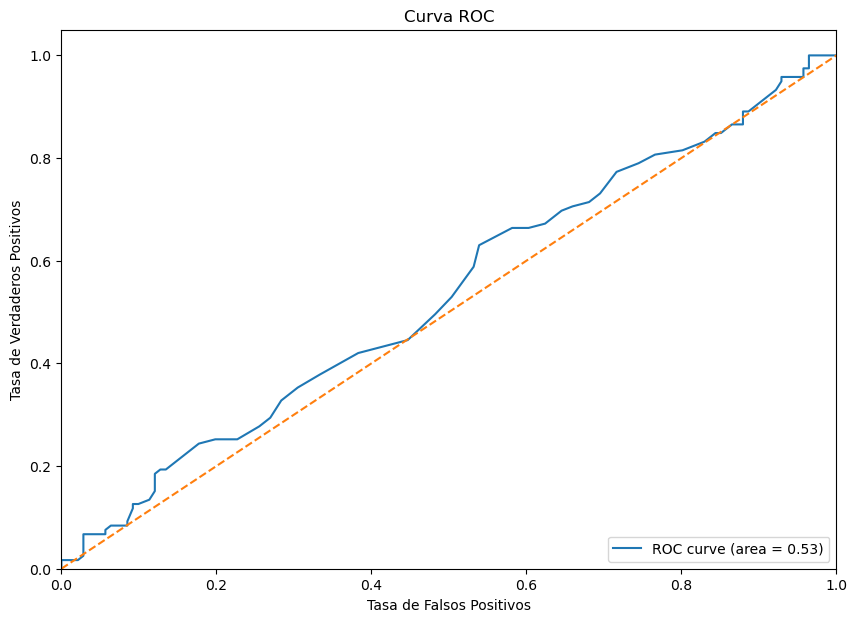

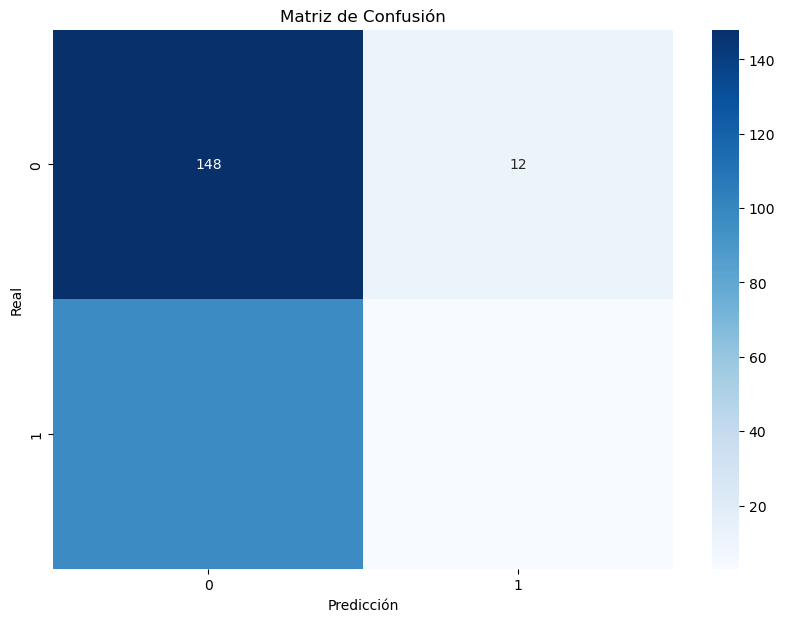

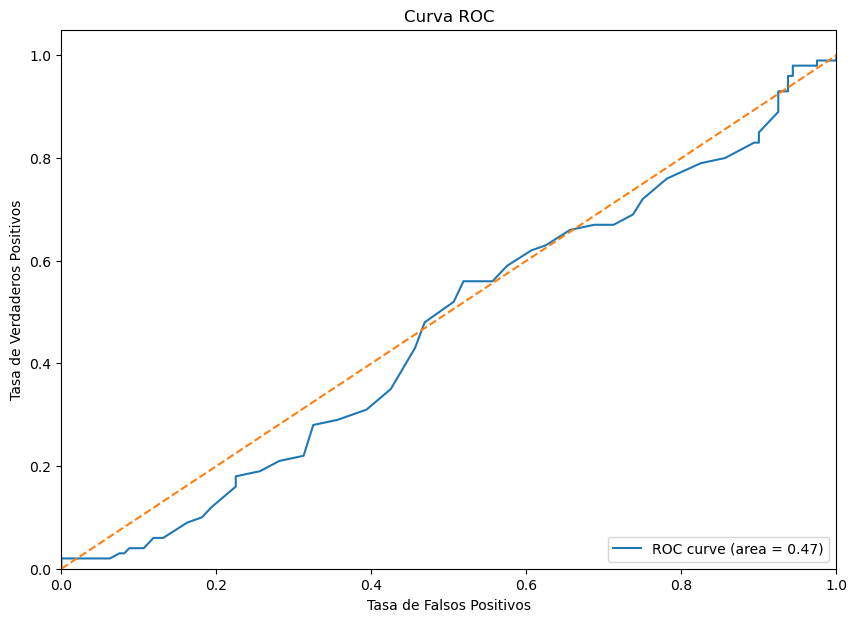

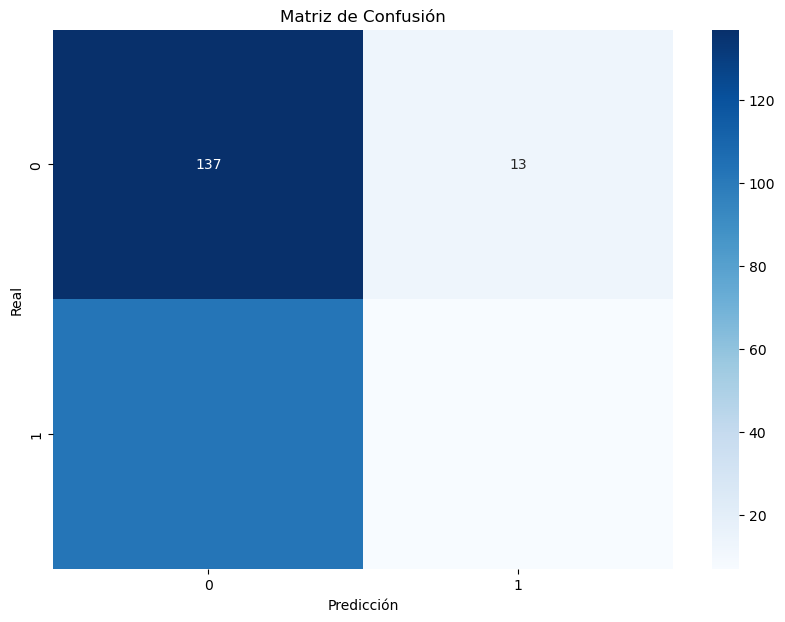

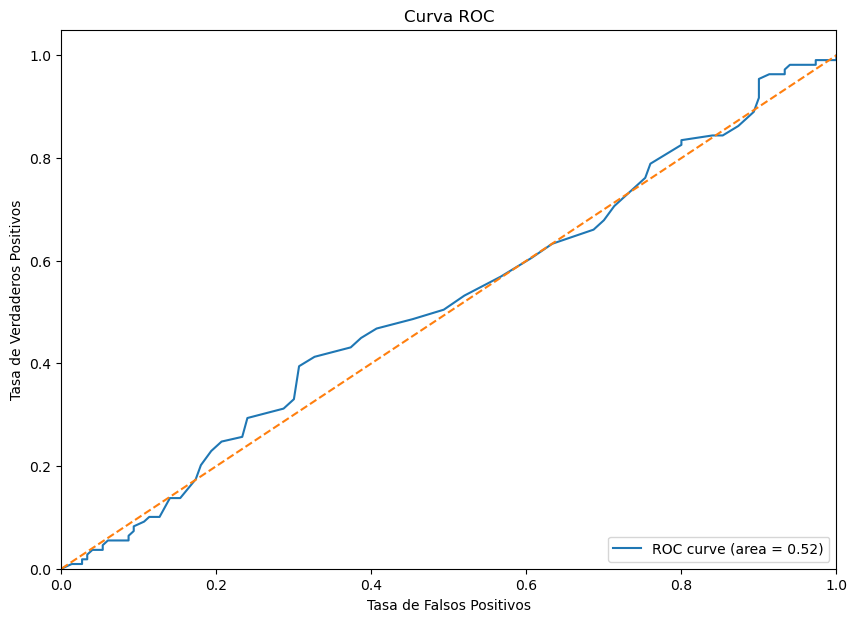

AttributeError: 'NoneType' object has no attribute 'split'

In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Supongamos que el DataFrame 'respondieron' ya está cargado y preparado
# Definir la variable dependiente 'y' y las independientes 'X'
X = respondieron.drop(columns=['pobre'])  # Elimina la variable dependiente de X
y = respondieron['pobre']  # Establece 'pobre' como la variable dependiente

# Convertir 'y' a un array de numpy
y = y.values

# Dividir los datos en conjuntos de entrenamiento y prueba (si es necesario, pero en este caso, usaremos todo el conjunto para k-fold)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Imputar los valores faltantes utilizando la media de cada columna
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Escalar los datos para mejorar la convergencia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

k=5
# Ejecutar la función evalua_multiples_metodos con los datos preparados
df_resultados = evalua_multiples_metodos(X_test_scaled, y, k)

# Mostrar los resultados
print(df_resultados)

## Ejercicio 5

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

Lambda óptimo para Ridge:  100
Lambda óptimo para LASSO:  10


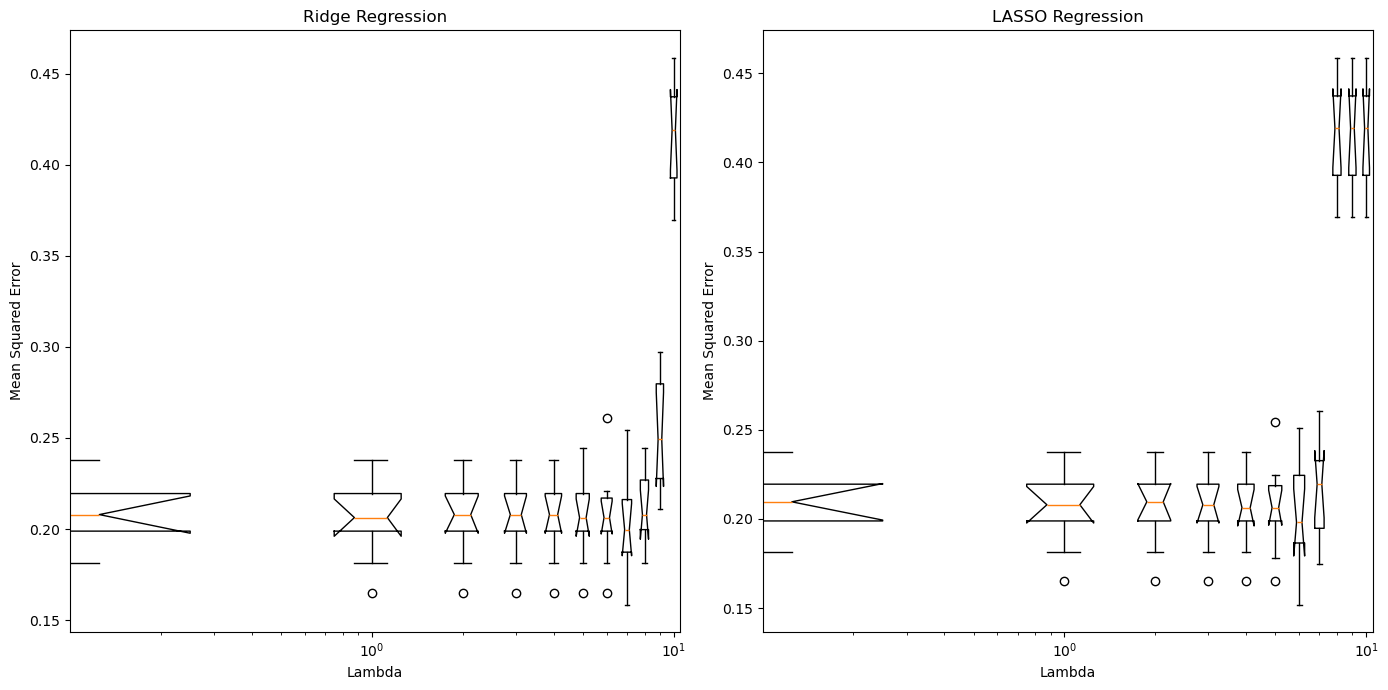

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

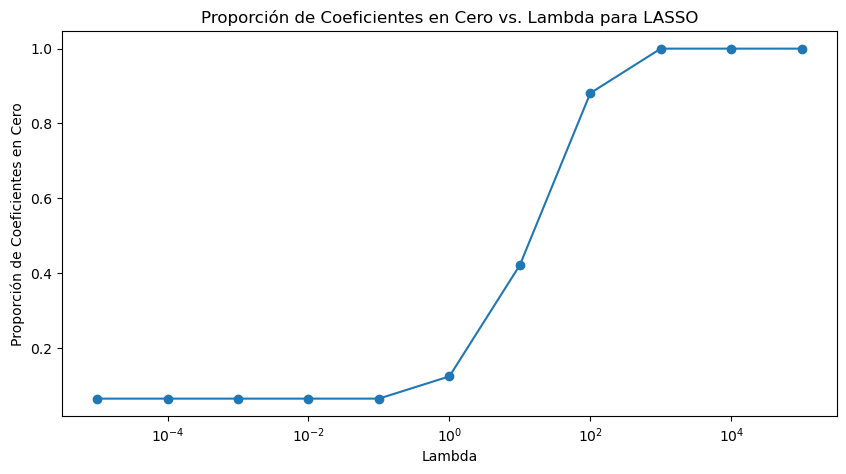

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def evalua_metodo(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    return error

def cross_validation(model, X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    errors = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        error = evalua_metodo(model, X_train, y_train, X_test, y_test)
        errors.append(error)
    return np.mean(errors), errors

lambdas = [10**i for i in range(-5, 6)]

ridge_errors = []
lasso_errors = []
ridge_errors_all = []
lasso_errors_all = []

for l in lambdas:
    ridge_model = LogisticRegression(penalty='l2', C=1/l, solver='saga', max_iter=100)
    lasso_model = LogisticRegression(penalty='l1', C=1/l, solver='saga', max_iter=100)

    ridge_error, ridge_error_list = cross_validation(ridge_model, X_train_scaled, y_train, 10)
    lasso_error, lasso_error_list = cross_validation(lasso_model, X_train_scaled, y_train, 10)
    
    ridge_errors.append(ridge_error)
    lasso_errors.append(lasso_error)
    ridge_errors_all.append(ridge_error_list)
    lasso_errors_all.append(lasso_error_list)

optimal_lambda_ridge = lambdas[np.argmin(ridge_errors)]
optimal_lambda_lasso = lambdas[np.argmin(lasso_errors)]

print("Lambda óptimo para Ridge: ", optimal_lambda_ridge)
print("Lambda óptimo para LASSO: ", optimal_lambda_lasso)

plt.figure(figsize=(14, 7))

# Boxplot para Ridge
plt.subplot(1, 2, 1)
plt.boxplot(ridge_errors_all, positions=range(len(lambdas)), notch=True)
plt.xticks(ticks=range(len(lambdas)), labels=lambdas)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression')

# Boxplot para LASSO
plt.subplot(1, 2, 2)
plt.boxplot(lasso_errors_all, positions=range(len(lambdas)), notch=True)
plt.xticks(ticks=range(len(lambdas)), labels=lambdas)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('LASSO Regression')

plt.tight_layout()
plt.show()

# Proporción de variables ignoradas por LASSO
lasso_zero_coefs = []

for l in lambdas:
    lasso_model = LogisticRegression(penalty='l1', C=1/l, solver='saga', max_iter=100)
    lasso_model.fit(X_train_scaled, y_train)
    zero_coefs = np.sum(lasso_model.coef_ == 0) / len(lasso_model.coef_[0])
    lasso_zero_coefs.append(zero_coefs)

plt.figure(figsize=(10, 5))
plt.plot(lambdas, lasso_zero_coefs, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Proporción de Coeficientes en Cero')
plt.title('Proporción de Coeficientes en Cero vs. Lambda para LASSO')
plt.show()


In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Supongamos que el DataFrame 'respondieron' ya está cargado y preparado
# Definir la variable dependiente 'y' y las independientes 'X'
X = respondieron.drop(columns=['pobre'])  # Elimina la variable dependiente de X
y = respondieron['pobre']  # Establece 'pobre' como la variable dependiente

# Convertir 'y' a un array de numpy
y = y.values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Imputar los valores faltantes utilizando la media de cada columna
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Escalar los datos para mejorar la convergencia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Ajustar el modelo Ridge con λ óptimo de 100
ridge_model = LogisticRegression(penalty='l2', C=1/100, solver='saga', max_iter=100)
ridge_model.fit(X_train_scaled, y_train)
coeficientes_ridge = ridge_model.coef_[0]

# Ajustar el modelo LASSO con λ óptimo de 10
lasso_model = LogisticRegression(penalty='l1', C=1/10, solver='saga', max_iter=100)
lasso_model.fit(X_train_scaled, y_train)
coeficientes_lasso = lasso_model.coef_[0]

# Identificar las variables descartadas por LASSO (coeficientes igual a cero)
variables_descartadas_lasso = np.where(coeficientes_lasso == 0)[0]
nombres_variables_descartadas_lasso = X.columns[variables_descartadas_lasso]

# Mostrar los resultados
print("Variables descartadas por LASSO con λ óptimo de 10:")
print(nombres_variables_descartadas_lasso)

# Mostrar los coeficientes del modelo Ridge
print("\nCoeficientes del modelo Ridge con λ óptimo de 100:")
for feature, coef in zip(X.columns, coeficientes_ridge):
    print(f"{feature}: {coef}")


Variables descartadas por LASSO con λ óptimo de 10:
Index(['ANO4', 'TRIMESTRE', 'H15', 'REGION', 'PONDERA', 'CH03', 'CH15_COD',
       'CH16', 'ESTADO', 'IMPUTA', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C6',
       'PP02C7', 'PP02C8', 'PP02H', 'PP02I', 'PP03C', 'PP03D', 'PP03H',
       'PP03I', 'PP04A', 'PP04B2', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA',
       'PP04C', 'PP04C99', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA',
       'PP05C_2', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06H', 'PP07D',
       'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4', 'PP07G1', 'PP07G2', 'PP07G3',
       'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP09B', 'PP09C', 'PP10C',
       'PP10D', 'PP11A', 'PP11B_COD', 'PP11B2_MES', 'PP11B2_DIA', 'PP11C',
       'PP11G_DIA', 'PP11L', 'PP11L1', 'PP11M', 'PP11O', 'PP11P', 'PP11R',
       'REALIZADA', 'II2', 'II4_1', 'II6', 'II9', 'V21', 'V12', 'V19_A',
       'V19_B', 'VII2_4', 'trabaja'],
      dtype='object')

Coeficientes del modelo Ridge con λ óptimo de 100:
ANO4: 0.0
TR

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Supongamos que el DataFrame 'respondieron' ya está cargado y preparado
# Definir la variable dependiente 'y' y las independientes 'X'
X = respondieron.drop(columns=['pobre'])  # Elimina la variable dependiente de X
y = respondieron['pobre']  # Establece 'pobre' como la variable dependiente

# Convertir 'y' a un array de numpy
y = y.values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Imputar los valores faltantes utilizando la media de cada columna
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Escalar los datos para mejorar la convergencia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Ajustar el modelo Ridge con λ óptimo de 100
ridge_model = LogisticRegression(penalty='l2', C=1/100, solver='saga', max_iter=2000)
ridge_model.fit(X_train_scaled, y_train)
coeficientes_ridge = ridge_model.coef_[0]

# Ajustar el modelo LASSO con λ óptimo de 10
lasso_model = LogisticRegression(penalty='l1', C=1/10, solver='saga', max_iter=2000)
lasso_model.fit(X_train_scaled, y_train)
coeficientes_lasso = lasso_model.coef_[0]

# Identificar las variables omitidas por LASSO (coeficientes igual a cero)
variables_omitidas_lasso = np.where(coeficientes_lasso == 0)[0]
nombres_variables_omitidas_lasso = X.columns[variables_omitidas_lasso]

# Identificar las variables omitidas por Ridge (coeficientes igual a cero)
variables_omitidas_ridge = np.where(coeficientes_ridge == 0)[0]
nombres_variables_omitidas_ridge = X.columns[variables_omitidas_ridge]

# Mostrar los resultados
print("Variables omitidas por LASSO con λ óptimo de 10:")
print(nombres_variables_omitidas_lasso)

print("\nVariables omitidas por Ridge con λ óptimo de 100:")
print(nombres_variables_omitidas_ridge)


Variables omitidas por LASSO con λ óptimo de 10:
Index(['ANO4', 'TRIMESTRE', 'H15', 'REGION', 'PONDERA', 'CH03', 'CH15_COD',
       'CH16', 'ESTADO', 'IMPUTA', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C6',
       'PP02C7', 'PP02C8', 'PP02H', 'PP02I', 'PP03C', 'PP03D', 'PP03H',
       'PP03I', 'PP04A', 'PP04B2', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA',
       'PP04C', 'PP04C99', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA',
       'PP05C_2', 'PP05E', 'PP05F', 'PP06A', 'PP06H', 'PP07D', 'PP07F1',
       'PP07F2', 'PP07F3', 'PP07F4', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4',
       'PP07G_59', 'PP07H', 'PP07I', 'PP09B', 'PP09C', 'PP10C', 'PP10D',
       'PP11A', 'PP11B_COD', 'PP11B2_MES', 'PP11B2_DIA', 'PP11C', 'PP11G_DIA',
       'PP11L', 'PP11L1', 'PP11M', 'PP11O', 'PP11P', 'PP11R', 'REALIZADA',
       'IV4', 'II3', 'II4_1', 'II6', 'II9', 'V21', 'V5', 'V12', 'V19_A',
       'V19_B', 'IX_MEN10', 'IX_MAYEQ10', 'VII2_4', 'trabaja'],
      dtype='object')

Variables omitidas por Ridge con λ ó

In [31]:
# Comparar el ECM de ambos métodos de regularización
ridge_ecm = min(ridge_errors)
lasso_ecm = min(lasso_errors)

print(f"ECM mínimo para Ridge: {ridge_ecm}")
print(f"ECM mínimo para LASSO: {lasso_ecm}")

if ridge_ecm < lasso_ecm:
    print("El método de regularización que funcionó mejor es Ridge.")
else:
    print("El método de regularización que funcionó mejor es LASSO.")

ECM mínimo para Ridge: 0.20165016501650163
ECM mínimo para LASSO: 0.20297029702970298
El método de regularización que funcionó mejor es Ridge.


In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def calcular_ecm_cv(model, X, y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    ecm_values = []
    
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        ecm_values.append(mean_squared_error(y_test_cv, y_pred_cv))
    
    return np.mean(ecm_values)

# Definir los modelos con los hiperparámetros óptimos
logistic_model = LogisticRegression(C=1/0.01, max_iter=2000)
lda_model = LinearDiscriminantAnalysis()
ridge_model = LogisticRegression(penalty='l2', C=1/100, solver='saga', max_iter=2000)
lasso_model = LogisticRegression(penalty='l1', C=1/10, solver='saga', max_iter=2000)

# Calcular el ECM para cada modelo usando validación cruzada
ecm_logistic_cv = calcular_ecm_cv(logistic_model, X_train_scaled, y_train)
ecm_lda_cv = calcular_ecm_cv(lda_model, X_train_scaled, y_train)
ecm_ridge_cv = calcular_ecm_cv(ridge_model, X_train_scaled, y_train)
ecm_lasso_cv = calcular_ecm_cv(lasso_model, X_train_scaled, y_train)

# Mostrar los resultados
print("Error Cuadrático Medio (ECM) de cada modelo con validación cruzada:")
print(f"Regresión Logística: {ecm_logistic_cv}")
print(f"Análisis de Discriminante Lineal: {ecm_lda_cv}")
print(f"Ridge Regression (λ=100): {ecm_ridge_cv}")
print(f"LASSO Regression (λ=10): {ecm_lasso_cv}")


Error Cuadrático Medio (ECM) de cada modelo con validación cruzada:
Regresión Logística: 0.20759075907590757
Análisis de Discriminante Lineal: 0.21155115511551154
Ridge Regression (λ=100): 0.20165016501650163
LASSO Regression (λ=10): 0.201980198019802
